# Publication Visualizations: Ergodic Insurance Analysis

Generates all publication-ready figures for the research paper.
Each chart is 300 DPI, colorblind-accessible (Okabe-Ito palette),
and styled for LaTeX/Computer Modern compatibility.

**Prerequisites:** Run `1. process_vol_sim_results.ipynb` to build `cache/dashboard_cache.pkl`.

See `VISUAL_SPECIFICATION.md` for the full design system.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
import numpy as np
import pickle
from pathlib import Path

# Publication rcParams (see VISUAL_SPECIFICATION.md)
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['CMU Serif', 'Computer Modern', 'Times New Roman', 'DejaVu Serif'],
    'font.size': 10, 'axes.titlesize': 11, 'axes.labelsize': 10,
    'xtick.labelsize': 9, 'ytick.labelsize': 9, 'legend.fontsize': 9,
    'legend.framealpha': 0.9, 'legend.edgecolor': '#CCCCCC',
    'figure.dpi': 150, 'savefig.dpi': 300,
    'savefig.bbox': 'tight', 'savefig.pad_inches': 0.1,
    'axes.spines.top': False, 'axes.spines.right': False,
    'axes.grid': True, 'axes.axisbelow': True,
    'grid.alpha': 0.3, 'grid.linestyle': '--', 'grid.linewidth': 0.5,
    'text.usetex': False, 'mathtext.fontset': 'cm',
})

# Okabe-Ito colorblind-safe palette
PAL = {
    'blue': '#0072B2', 'orange': '#E69F00', 'green': '#009E73',
    'vermillion': '#D55E00', 'purple': '#CC79A7', 'sky': '#56B4E9',
    'yellow': '#F0E442', 'gray': '#999999', 'dark': '#333333',
}
DED_COLORS = {0: PAL['blue'], 100_000: PAL['sky'], 250_000: PAL['orange'], 500_000: PAL['vermillion']}
DED_LABELS = {0: '$0', 100_000: '$100K', 250_000: '$250K', 500_000: '$500K'}

# Extended maps including No Insurance
DED_COLORS_EXT = {**DED_COLORS, 'noins': PAL['gray']}
DED_LABELS_EXT = {**DED_LABELS, 'noins': 'No Insurance'}

# Line widths
LW_EM, LW_STD, LW_REF, LW_THIN = 2.5, 1.5, 1.0, 0.3

OUTPUT = Path('output/publication')
OUTPUT.mkdir(parents=True, exist_ok=True)

def fmt(n):
    if abs(n) >= 1e9: return f'${n/1e9:.0f}B'
    if abs(n) >= 1e6: return f'${n/1e6:.0f}M'
    if abs(n) >= 1e3: return f'${n/1e3:.0f}K'
    return f'${n:.0f}'

def save(fig, name):
    p = OUTPUT / f'{name}.png'
    fig.savefig(p, dpi=300, facecolor='white')
    print(f'Saved: {p}')

# Growth Rate Decomposition Table ($5M Cap, ATR=1.0)
# Source: GC_SUPERIORITY_EXPLANATION.md investigation
# g_naive = analytical (ignoring tax timing)
# g_det = 50-year deterministic simulation (with accrual taxes)
# g_actual = mean of 250K MC paths (with GBM sigma=0.15)
# stoch_pen = g_det - g_actual (stochastic volatility penalty)
DECOMP = {
    '$0K':    {'g_naive': 382.9, 'g_det': 212.7, 'g_actual': 235.0, 'tax_drag': 170.2, 'stoch_pen': -22.3},
    '$100K':  {'g_naive': 412.0, 'g_det': 229.3, 'g_actual': 175.7, 'tax_drag': 182.7, 'stoch_pen':  53.6},
    '$250K':  {'g_naive': 418.3, 'g_det': 232.9, 'g_actual': 160.2, 'tax_drag': 185.4, 'stoch_pen':  72.7},
    '$500K':  {'g_naive': 423.9, 'g_det': 236.1, 'g_actual': 146.5, 'tax_drag': 187.8, 'stoch_pen':  89.6},
    'No Ins': {'g_naive': 464.9, 'g_det': 259.6, 'g_actual': 123.5, 'tax_drag': 205.3, 'stoch_pen': 136.1},
}

# Retained loss volatility (% of $5M assets, Year 1)
RETAINED_VOL = {
    '$0K': {'std_pct': 0.00, 'max_pct': 0.00},
    '$100K': {'std_pct': 1.25, 'max_pct': 10.49},
    '$250K': {'std_pct': 1.85, 'max_pct': 20.51},
    '$500K': {'std_pct': 2.66, 'max_pct': 34.49},
    'No Ins': {'std_pct': 19.93, 'max_pct': 1429.44},
}

# Pricing parameters for sensitivity analysis
# From run_vol_sim_colab.py pricing simulation at $5M Cap, ATR=1.0
PRICING = {
    'EBITABL': 0.125,
    'tax_rate': 0.25,
    'retention_ratio': 0.70,
    'base_LR': 0.70,
    'expected_losses': {  # E[insured_loss] per year at base revenue ($5M)
        '$0K': 182_264,
        '$100K': 117_529,
        '$250K': 103_500,
        '$500K':  91_125,
    },
    'expected_retained': {  # E[retained_loss] per year at base revenue ($5M)
        '$0K': 0,
        '$100K': 64_734,
        '$250K': 78_763,
        '$500K': 91_139,
    },
    'revenue': 5_000_000,
}

In [2]:
import gc

# Load dashboard cache
with open('cache/dashboard_cache.pkl', 'rb') as f:
    cache = pickle.load(f)
configs = cache['configs']
crn_pairs = cache['crn_pairs']
param_values = cache['param_values']
RESULTS_DIR = Path(cache['results_dir'])

def find_key(cap, atr, ded=None, noins=False):
    for k, c in configs.items():
        if c['Cap'] == cap and c['ATR'] == atr:
            if noins and c.get('NOINS'): return k
            if not noins and not c.get('NOINS') and c.get('Ded') == ded: return k
    return None

def ruin_val(cfg, yr):
    rp = cfg['ruin_probability']
    for k, v in rp.items():
        if int(k) == yr: return v
    return None

def get_per_sim_ruin(key, min_trailing=2):
    """Identify ruined sims from trailing zeros in annual_losses.

    The simulation breaks out of the year loop on ruin, leaving trailing zeros
    in pre-allocated loss arrays. Sims with >= min_trailing consecutive trailing
    zero years are classified as ruined. This is needed because the simulation
    tracks ruin via equity <= 0 OR payment_burden > 80%, but per-sim ruin flags
    are not stored in SimulationResults — only the aggregate ruin_probability.
    Using min_trailing=2 matches the aggregate ruin_probability within ~0.4%.
    """
    path = RESULTS_DIR / f'{key}.pkl'
    with open(path, 'rb') as f:
        data = pickle.load(f)
    losses = data.annual_losses
    n_sims, n_years = losses.shape
    last_active = np.full(n_sims, -1, dtype=int)
    for yr in range(n_years - 1, -1, -1):
        active = (losses[:, yr] != 0) & (last_active == -1)
        last_active[active] = yr
    ruined = last_active < (n_years - min_trailing)
    del data
    gc.collect()
    return ruined

# Load growth_rates and final_assets from pickles
sim = {}  # key -> {'gr': array, 'fa': array}
def load_sim(key):
    if key in sim: return sim[key]
    path = RESULTS_DIR / f'{key}.pkl'
    with open(path, 'rb') as f:
        data = pickle.load(f)
    sim[key] = {'gr': data.growth_rates.copy(), 'fa': data.final_assets.copy()}
    del data
    return sim[key]

# Preload key configs
print('Loading simulation arrays...')
for cap in param_values['Cap']:
    for atr in param_values['ATR']:
        k = find_key(cap, atr, noins=True)
        if k:
            load_sim(k)
            print(f'  NOINS Cap={cap/1e6:.0f}M ATR={atr}')
        for ded in param_values['Ded']:
            k = find_key(cap, atr, ded=ded)
            if k:
                load_sim(k)
                print(f'  Ins   Cap={cap/1e6:.0f}M ATR={atr} Ded={ded/1e3:.0f}K')
print(f'Loaded {len(sim)} configs')

Loading simulation arrays...
  NOINS Cap=5M ATR=0.8
  Ins   Cap=5M ATR=0.8 Ded=0K
  Ins   Cap=5M ATR=0.8 Ded=100K
  Ins   Cap=5M ATR=0.8 Ded=250K
  Ins   Cap=5M ATR=0.8 Ded=500K
  NOINS Cap=5M ATR=1
  Ins   Cap=5M ATR=1 Ded=0K
  Ins   Cap=5M ATR=1 Ded=100K
  Ins   Cap=5M ATR=1 Ded=250K
  Ins   Cap=5M ATR=1 Ded=500K
  NOINS Cap=5M ATR=1.2
  Ins   Cap=5M ATR=1.2 Ded=0K
  Ins   Cap=5M ATR=1.2 Ded=100K
  Ins   Cap=5M ATR=1.2 Ded=250K
  Ins   Cap=5M ATR=1.2 Ded=500K
  NOINS Cap=10M ATR=0.8
  Ins   Cap=10M ATR=0.8 Ded=0K
  Ins   Cap=10M ATR=0.8 Ded=100K
  Ins   Cap=10M ATR=0.8 Ded=250K
  Ins   Cap=10M ATR=0.8 Ded=500K
  NOINS Cap=10M ATR=1
  Ins   Cap=10M ATR=1 Ded=0K
  Ins   Cap=10M ATR=1 Ded=100K
  Ins   Cap=10M ATR=1 Ded=250K
  Ins   Cap=10M ATR=1 Ded=500K
  NOINS Cap=10M ATR=1.2
  Ins   Cap=10M ATR=1.2 Ded=0K
  Ins   Cap=10M ATR=1.2 Ded=100K
  Ins   Cap=10M ATR=1.2 Ded=250K
  Ins   Cap=10M ATR=1.2 Ded=500K
  NOINS Cap=25M ATR=0.8
  Ins   Cap=25M ATR=0.8 Ded=0K
  Ins   Cap=25M ATR=0.8 Ded

## 2. Optimal Deductible Heatmap
Core actionable result: which deductible maximizes time-average growth rate for each (Cap, ATR) combination.

Saved: output\publication\optimal_deductible_heatmap.png


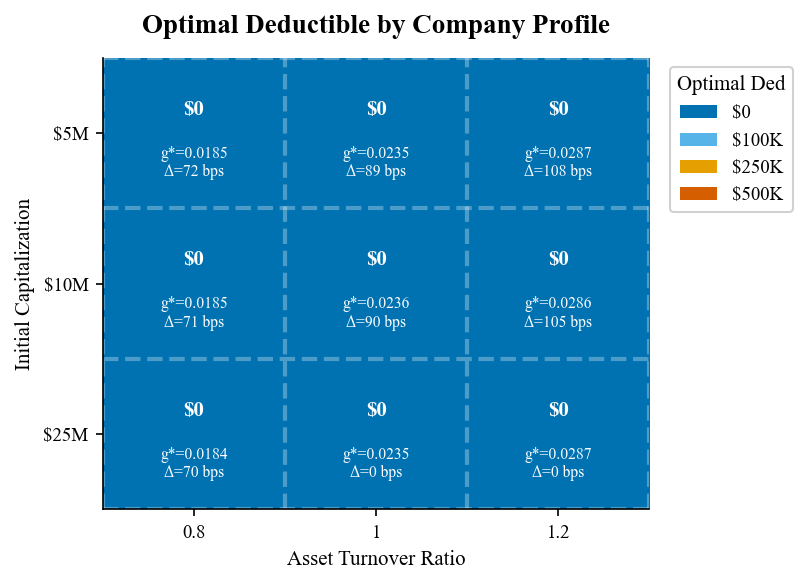

In [3]:
caps = param_values['Cap']
atrs = param_values['ATR']
deds = param_values['Ded']

# Build growth rate matrix and find optimal
opt_ded = np.full((len(caps), len(atrs)), np.nan)
opt_gr = np.full((len(caps), len(atrs)), np.nan)
worst_gr = np.full((len(caps), len(atrs)), np.nan)
penalty = np.full((len(caps), len(atrs)), np.nan)

for i, cap in enumerate(caps):
    for j, atr in enumerate(atrs):
        best_g, best_d, worst_g = -np.inf, None, np.inf
        for ded in deds:
            k = find_key(cap, atr, ded=ded)
            if k is None: continue
            g = configs[k]['growth_rate_mean']
            if g > best_g: best_g, best_d = g, ded
            if g < worst_g: worst_g = g
        if best_d is not None:
            opt_ded[i, j] = best_d
            opt_gr[i, j] = best_g
            worst_gr[i, j] = worst_g
            penalty[i, j] = (best_g - worst_g) * 10_000  # basis points

# Plot heatmap
fig, ax = plt.subplots(figsize=(5.5, 4.0))

# Map deductible values to indices for coloring
ded_to_idx = {d: i for i, d in enumerate(deds)}
color_matrix = np.array([[ded_to_idx.get(opt_ded[i, j], -1) for j in range(len(atrs))] for i in range(len(caps))])
cmap = mcolors.ListedColormap([DED_COLORS[d] for d in deds])
bounds = np.arange(-0.5, len(deds) + 0.5, 1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

im = ax.imshow(color_matrix, cmap=cmap, norm=norm, aspect='auto')

# Annotate cells
for i in range(len(caps)):
    for j in range(len(atrs)):
        if np.isnan(opt_ded[i, j]):
            ax.text(j, i, 'N/A', ha='center', va='center', fontsize=9, color=PAL['gray'])
        else:
            txt_color = 'white' if color_matrix[i, j] in [0, 3] else PAL['dark']
            ax.text(j, i - 0.15, DED_LABELS[int(opt_ded[i, j])],
                    ha='center', va='center', fontsize=10, fontweight='bold', color=txt_color)
            ax.text(j, i + 0.2,
                    f'g*={opt_gr[i,j]:.4f}\n\u0394={penalty[i,j]:.0f} bps',
                    ha='center', va='center', fontsize=7.5, color=txt_color)

ax.set_xticks(range(len(atrs)))
ax.set_xticklabels([str(a) for a in atrs])
ax.set_yticks(range(len(caps)))
ax.set_yticklabels([fmt(c) for c in caps])
ax.set_xlabel('Asset Turnover Ratio')
ax.set_ylabel('Initial Capitalization')
ax.set_title('Optimal Deductible by Company Profile', fontsize=13, fontweight='bold', pad=12)

# Grid between cells
ax.set_xticks(np.arange(-0.5, len(atrs), 1), minor=True)
ax.set_yticks(np.arange(-0.5, len(caps), 1), minor=True)
ax.grid(which='minor', color='white', linewidth=2)
ax.grid(which='major', visible=False)
ax.tick_params(which='minor', size=0)

# Legend
from matplotlib.patches import Patch
legend_patches = [Patch(facecolor=DED_COLORS[d], label=DED_LABELS[d]) for d in deds]
ax.legend(handles=legend_patches, loc='upper left', bbox_to_anchor=(1.02, 1), title='Optimal Ded')

fig.tight_layout()
save(fig, 'optimal_deductible_heatmap')
plt.show()

## 3. Wealth Trajectory Fan Chart
Insured vs. uninsured wealth evolution over 50 years. Percentile envelopes
from surviving paths only; vermillion dots mark insolvency events where
liabilities exceeded assets (equity ≤ 0). Note: ruin means balance-sheet
insolvency, not total assets reaching zero.

Saved: output\publication\wealth_fan_chart.png


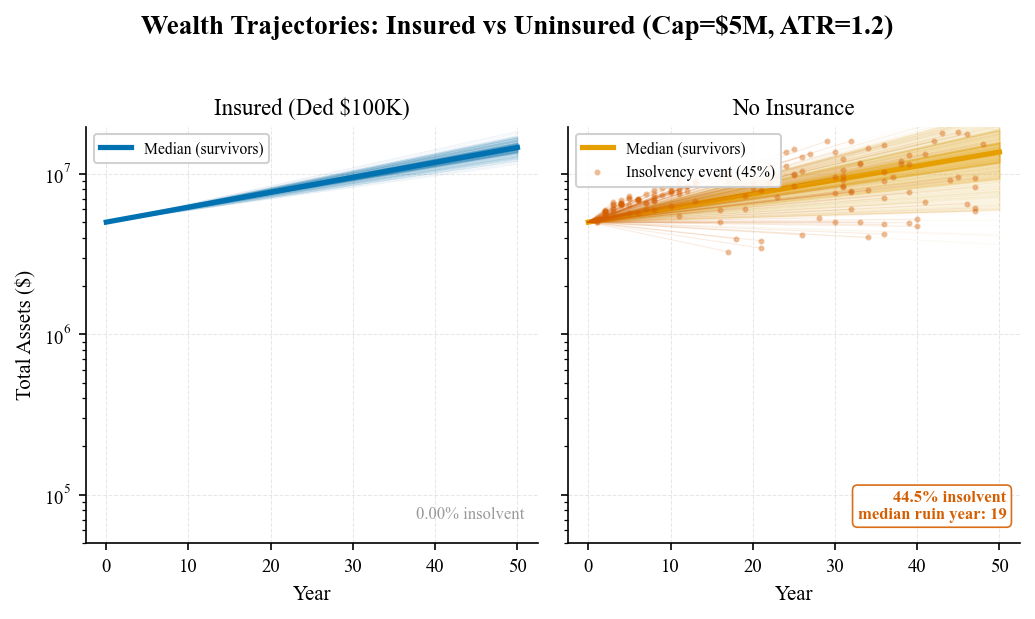

In [4]:
CAP, ATR, DED = 5_000_000, 1.2, 100_000
A0 = CAP
years = np.arange(51)
bands = [(5, 95, 0.10), (25, 75, 0.20), (40, 60, 0.35)]

def load_ruin_years(key):
    """Detect ruin year per sim from trailing zeros in annual_losses.
    Returns -1 for survivors, ruin year (0-indexed) for ruined paths."""
    path = RESULTS_DIR / f'{key}.pkl'
    with open(path, 'rb') as f:
        data = pickle.load(f)
    losses = data.annual_losses
    n_sims, n_years = losses.shape
    last_active = np.full(n_sims, -1, dtype=int)
    for yr in range(n_years - 1, -1, -1):
        mask = (losses[:, yr] != 0) & (last_active == -1)
        last_active[mask] = yr
    ruined = last_active < (n_years - 2)
    ruin_year = np.where(ruined, last_active + 1, -1)
    del data
    gc.collect()
    return ruin_year

fig, axes = plt.subplots(1, 2, figsize=(7.0, 4.0), sharey=True)

for ax_idx, (label, noins_flag, ded_val, base_color) in enumerate([
    (f'Insured (Ded {DED_LABELS[DED]})', False, DED, PAL['blue']),
    ('No Insurance', True, None, PAL['orange']),
]):
    ax = axes[ax_idx]
    k = find_key(CAP, ATR, ded=ded_val, noins=noins_flag)
    if k is None:
        ax.set_title(f'{label} (no data)'); continue

    g = sim[k]['gr']
    fa = sim[k]['fa']
    ry = load_ruin_years(k)

    survived = ry == -1
    ruined = ry >= 0
    n_ruined = ruined.sum()
    ruin_pct = n_ruined / len(g)
    g_surv = g[survived]

    rng = np.random.default_rng(42)

    # --- Surviving paths: spaghetti + fan ---
    n_surv_sample = min(300, survived.sum())
    surv_idx = rng.choice(np.where(survived)[0], size=n_surv_sample, replace=False)
    for si in surv_idx:
        y = A0 * np.exp(g[si] * years)
        ax.plot(years, y, color=base_color, alpha=0.04, lw=LW_THIN)

    for lo, hi, alpha in bands:
        g_lo = np.percentile(g_surv, lo)
        g_hi = np.percentile(g_surv, hi)
        ax.fill_between(years, A0 * np.exp(g_lo * years),
                        A0 * np.exp(g_hi * years), color=base_color, alpha=alpha)

    ax.plot(years, A0 * np.exp(np.median(g_surv) * years),
            color=base_color, lw=LW_EM, label='Median (survivors)')

    # --- Ruined paths: terminated trajectories + insolvency dots ---
    if n_ruined > 50:
        n_ruin_sample = min(150, n_ruined)
        ruin_idx = rng.choice(np.where(ruined)[0], size=n_ruin_sample, replace=False)
        ruin_x, ruin_y = [], []
        for si in ruin_idx:
            ruin_yr = ry[si]
            if ruin_yr <= 0: continue
            g_to_ruin = np.log(float(fa[si]) / A0) / ruin_yr
            t_path = np.arange(ruin_yr + 1)
            y_path = A0 * np.exp(g_to_ruin * t_path)
            ax.plot(t_path, y_path, color=PAL['vermillion'], alpha=0.12, lw=0.5)
            ruin_x.append(ruin_yr)
            ruin_y.append(y_path[-1])

        ax.scatter(ruin_x, ruin_y, color=PAL['vermillion'], s=4, alpha=0.3,
                   zorder=4, label=f'Insolvency event ({ruin_pct:.0%})')

        median_ry = np.median(ry[ruined])
        ax.text(0.97, 0.05,
                f'{ruin_pct:.1%} insolvent\nmedian ruin year: {median_ry:.0f}',
                transform=ax.transAxes, fontsize=8, ha='right', va='bottom',
                color=PAL['vermillion'], fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.9,
                          ec=PAL['vermillion'], lw=0.8))
    elif ruin_pct > 0:
        ax.text(0.97, 0.05, f'{ruin_pct:.2%} insolvent',
                transform=ax.transAxes, fontsize=8, ha='right', va='bottom',
                color=PAL['gray'])

    ax.set_yscale('log')
    ax.set_ylim(5e4, None)
    ax.set_title(label, fontsize=11)
    ax.set_xlabel('Year')
    ax.legend(loc='upper left', fontsize=7.5)

axes[0].set_ylabel('Total Assets ($)')
fig.suptitle(
    f'Wealth Trajectories: Insured vs Uninsured (Cap={fmt(CAP)}, ATR={ATR})',
    fontsize=13, fontweight='bold', y=1.02,
)
fig.tight_layout()
save(fig, 'wealth_fan_chart')
plt.show()

## 4. Survival Curves
Fraction of companies still solvent at each evaluation year,
across deductible levels. Shows how ruin accumulates over time.

Saved: output\publication\survival_curves.png


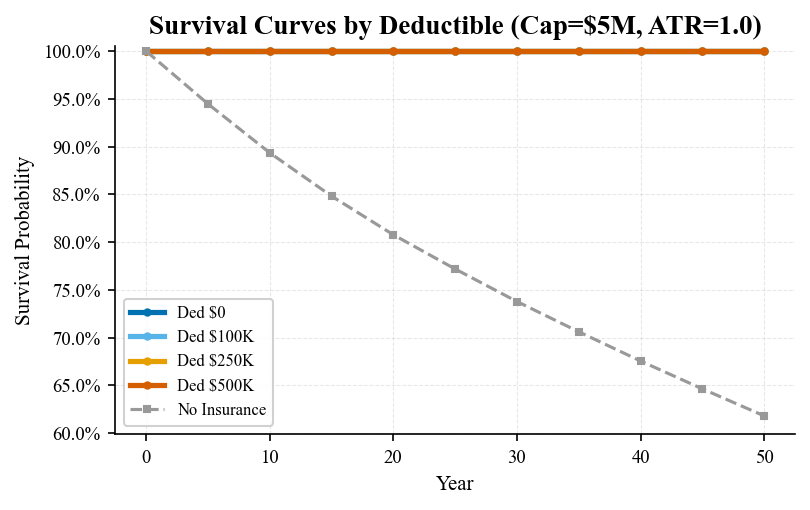

In [5]:
CAP, ATR = 5_000_000, 1.0

fig, ax = plt.subplots(figsize=(5.5, 3.5))

# Plot survival for each deductible + NOINS
for ded in deds:
    k = find_key(CAP, ATR, ded=ded)
    if k is None: continue
    rp = configs[k]['ruin_probability']
    eval_years = sorted(rp.keys(), key=int)
    xs = [0] + [int(y) for y in eval_years]
    ys = [1.0] + [1.0 - rp[y] for y in eval_years]
    ax.plot(xs, ys, color=DED_COLORS[ded], lw=LW_EM, marker='o', ms=3,
            label=f'Ded {DED_LABELS[ded]}')

# NOINS baseline
k_ni = find_key(CAP, ATR, noins=True)
if k_ni:
    rp_ni = configs[k_ni]['ruin_probability']
    eval_years_ni = sorted(rp_ni.keys(), key=int)
    xs_ni = [0] + [int(y) for y in eval_years_ni]
    ys_ni = [1.0] + [1.0 - rp_ni[y] for y in eval_years_ni]
    ax.plot(xs_ni, ys_ni, color=PAL['gray'], lw=LW_STD, ls='--', marker='s', ms=3,
            label='No Insurance')

ax.set_xlabel('Year')
ax.set_ylabel('Survival Probability')
ax.set_title(
    f'Survival Curves by Deductible (Cap={fmt(CAP)}, ATR={ATR})',
    fontsize=13, fontweight='bold',
)
ax.set_ylim(None, 1.005)
ax.yaxis.set_major_formatter(mticker.PercentFormatter(1.0, decimals=1))
ax.legend(loc='lower left', fontsize=8)

fig.tight_layout()
save(fig, 'survival_curves')
plt.show()

## 6. Year-by-Year Growth Lift
Insurance value compounds over time. Shows cumulative log-wealth
advantage of insured vs. uninsured.

Saved: output\publication\year_by_year_growth_lift.png


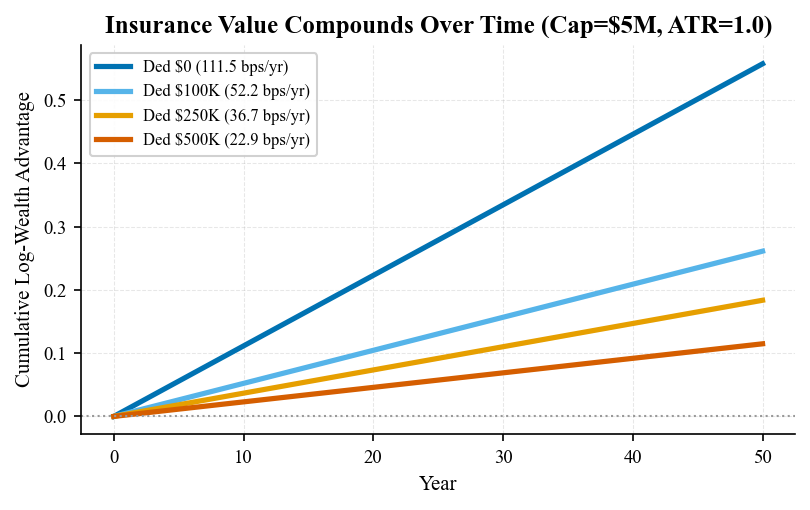

In [6]:
CAP, ATR = 5_000_000, 1.0
years = np.arange(51)

k_ni = find_key(CAP, ATR, noins=True)
g_ni = sim[k_ni]['gr'] if k_ni else None

fig, ax = plt.subplots(figsize=(5.5, 3.5))

for ded in deds:
    k_ins = find_key(CAP, ATR, ded=ded)
    if k_ins is None or g_ni is None: continue
    g_ins = sim[k_ins]['gr']

    # Paired growth lift at each year
    # lift(t) = mean(g_ins_i * t - g_ni_i * t) = mean(delta_i) * t
    delta = g_ins - g_ni  # CRN-paired differences
    mean_delta = delta.mean()
    se_delta = delta.std() / np.sqrt(len(delta))

    lift = mean_delta * years
    lift_upper = (mean_delta + 1.96 * se_delta) * years
    lift_lower = (mean_delta - 1.96 * se_delta) * years

    ax.plot(years, lift, color=DED_COLORS[ded], lw=LW_EM,
            label=f'Ded {DED_LABELS[ded]} ({mean_delta*1e4:.1f} bps/yr)')
    ax.fill_between(years, lift_lower, lift_upper,
                    color=DED_COLORS[ded], alpha=0.10)

ax.axhline(0, color=PAL['gray'], ls=':', lw=LW_REF)
ax.set_xlabel('Year')
ax.set_ylabel('Cumulative Log-Wealth Advantage')
ax.set_title(
    f'Insurance Value Compounds Over Time (Cap={fmt(CAP)}, ATR={ATR})',
    fontsize=12, fontweight='bold',
)
ax.legend(loc='upper left', fontsize=8)

fig.tight_layout()
save(fig, 'year_by_year_growth_lift')
plt.show()

## 7. Peer Benchmark Is Wrong
Two companies with identical revenue but different balance sheets
should make fundamentally different insurance decisions.

Saved: output\publication\peer_benchmark_is_wrong.png


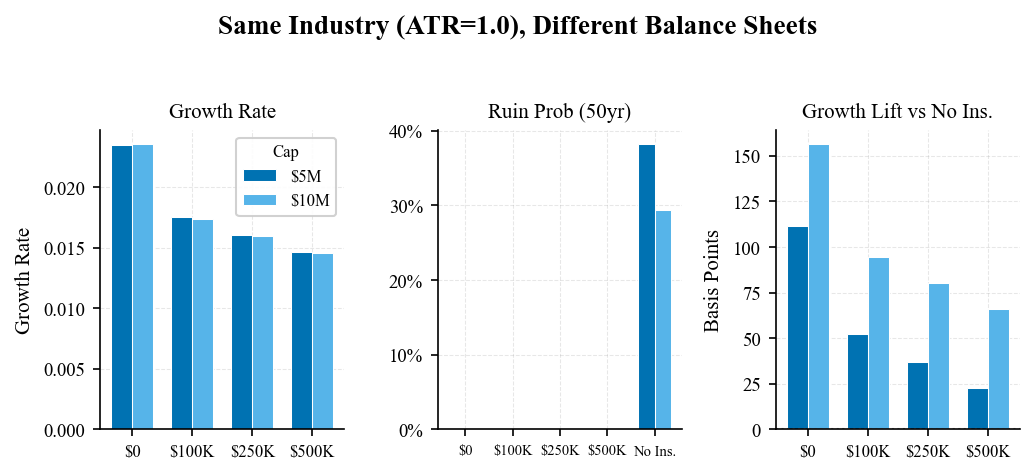

In [7]:
ATR_COMMON = 1.0
# Only $5M and $10M have full data (all deductibles + NOINS); $25M lacks NOINS baseline
caps_compare = [5_000_000, 10_000_000]
cap_colors = [PAL['blue'], PAL['sky']]

fig, axes = plt.subplots(1, 3, figsize=(7.0, 3.0))

# Panel 1: Growth rate by deductible for each Cap
ax = axes[0]
bar_w = 0.35
for ci, cap in enumerate(caps_compare):
    grs = []
    for ded in deds:
        k = find_key(cap, ATR_COMMON, ded=ded)
        grs.append(configs[k]['growth_rate_mean'] if k else np.nan)
    x = np.arange(len(deds)) + ci * bar_w
    ax.bar(x, grs, bar_w, color=cap_colors[ci],
           label=fmt(cap), edgecolor='white', lw=0.5)
ax.set_xticks(np.arange(len(deds)) + bar_w / 2)
ax.set_xticklabels([DED_LABELS[d] for d in deds], fontsize=8)
ax.set_ylabel('Growth Rate')
ax.set_title('Growth Rate', fontsize=10)
ax.legend(title='Cap', fontsize=8, title_fontsize=8)

# Panel 2: Ruin probability (year 50) - include NOINS baseline
ax = axes[1]
ded_labels_ext = [DED_LABELS[d] for d in deds] + ['No Ins.']
for ci, cap in enumerate(caps_compare):
    ruin_50s = []
    for ded in deds:
        k = find_key(cap, ATR_COMMON, ded=ded)
        ruin_50s.append(ruin_val(configs[k], 50) if k else np.nan)
    k_ni = find_key(cap, ATR_COMMON, noins=True)
    ruin_50s.append(ruin_val(configs[k_ni], 50) if k_ni else np.nan)
    x = np.arange(len(ded_labels_ext)) + ci * bar_w
    ax.bar(x, ruin_50s, bar_w, color=cap_colors[ci], edgecolor='white', lw=0.5)
ax.set_xticks(np.arange(len(ded_labels_ext)) + bar_w / 2)
ax.set_xticklabels(ded_labels_ext, fontsize=7)
ax.yaxis.set_major_formatter(mticker.PercentFormatter(1.0, decimals=0))
ax.set_title('Ruin Prob (50yr)', fontsize=10)

# Panel 3: Growth lift over no-insurance
ax = axes[2]
for ci, cap in enumerate(caps_compare):
    k_ni = find_key(cap, ATR_COMMON, noins=True)
    if k_ni is None: continue
    g_ni = configs[k_ni]['growth_rate_mean']
    lifts = []
    for ded in deds:
        k = find_key(cap, ATR_COMMON, ded=ded)
        lifts.append((configs[k]['growth_rate_mean'] - g_ni) * 1e4 if k else np.nan)
    x = np.arange(len(deds)) + ci * bar_w
    ax.bar(x, lifts, bar_w, color=cap_colors[ci], edgecolor='white', lw=0.5)
ax.set_xticks(np.arange(len(deds)) + bar_w / 2)
ax.set_xticklabels([DED_LABELS[d] for d in deds], fontsize=8)
ax.axhline(0, color=PAL['gray'], ls=':', lw=LW_REF)
ax.set_ylabel('Basis Points')
ax.set_title('Growth Lift vs No Ins.', fontsize=10)

fig.suptitle(
    f'Same Industry (ATR={ATR_COMMON}), Different Balance Sheets',
    fontsize=13, fontweight='bold', y=1.04,
)
fig.tight_layout()
save(fig, 'peer_benchmark_is_wrong')
plt.show()

## 8. Insurance Outcome Distribution ($0 Ded vs No Insurance)
Combined view: the distribution of per-path insurance value (left) and
key outcome metrics (right). Only the two extreme strategies are compared
since $0 deductible dominates all configurations.

Saved: output\publication\insurance_outcome_distribution.png


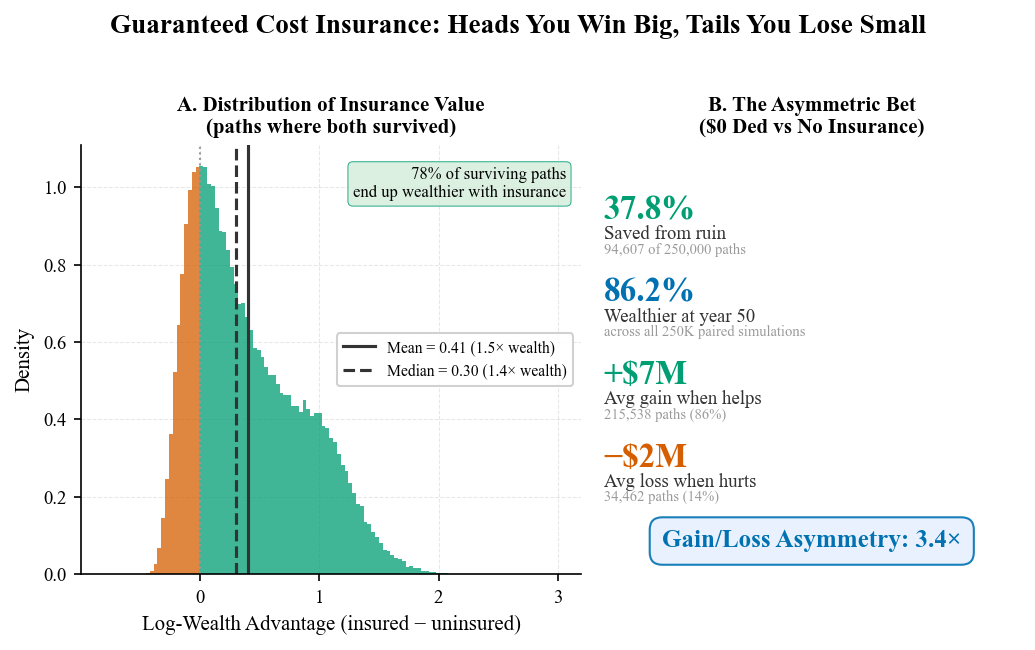

In [8]:
# === Insurance Outcome Distribution: $0 Ded vs No Insurance ===
CAP, ATR, DED = 5_000_000, 1.0, 0
k_ni = find_key(CAP, ATR, noins=True)
k_ins = find_key(CAP, ATR, ded=DED)
fa_ni = sim[k_ni]['fa']
fa_ins = sim[k_ins]['fa']

# Ruin detection
ruined_ni = get_per_sim_ruin(k_ni)
ruined_ins = get_per_sim_ruin(k_ins)

n = len(fa_ins)
both_ok = (~ruined_ins) & (~ruined_ni)
ins_saved = (~ruined_ins) & ruined_ni

# Delta for both-survived paths
delta_survived = np.log(fa_ins[both_ok].astype(float)) - np.log(fa_ni[both_ok].astype(float))

# Outperformance across ALL paths
outperform_all = fa_ins > fa_ni
delta_all = fa_ins.astype(float) - fa_ni.astype(float)
helps = delta_all > 0
avg_gain = delta_all[helps].mean()
avg_loss = abs(delta_all[~helps].mean())
ratio = avg_gain / avg_loss

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7.0, 4.2),
                                gridspec_kw={'width_ratios': [1.2, 1]})

# --- Panel A: Distribution of log-wealth advantage ---
bins = np.linspace(-0.8, 3.0, 120)
bin_centers = (bins[:-1] + bins[1:]) / 2
counts, _ = np.histogram(delta_survived, bins=bins)
density = counts / (counts.sum() * (bins[1] - bins[0]))
colors_hist = [PAL['green'] if bc > 0 else PAL['vermillion'] for bc in bin_centers]

ax1.bar(bin_centers, density, width=bins[1]-bins[0], color=colors_hist,
        edgecolor='none', alpha=0.75)
ax1.axvline(delta_survived.mean(), color=PAL['dark'], lw=LW_STD, ls='-',
            label=f'Mean = {delta_survived.mean():.2f} (1.5\u00d7 wealth)')
ax1.axvline(np.median(delta_survived), color=PAL['dark'], lw=LW_STD, ls='--',
            label=f'Median = {np.median(delta_survived):.2f} (1.4\u00d7 wealth)')
ax1.axvline(0, color=PAL['gray'], ls=':', lw=LW_REF)

frac_pos = (delta_survived > 0).mean()
ax1.text(0.97, 0.95,
         f'{frac_pos:.0%} of surviving paths\nend up wealthier with insurance',
         transform=ax1.transAxes, fontsize=8, ha='right', va='top',
         bbox=dict(boxstyle='round,pad=0.3', fc='#D4EDDA', alpha=0.8,
                   ec=PAL['green'], lw=0.5))

ax1.set_xlabel('Log-Wealth Advantage (insured \u2212 uninsured)')
ax1.set_ylabel('Density')
ax1.set_title('A. Distribution of Insurance Value\n(paths where both survived)',
              fontsize=10, fontweight='bold')
ax1.legend(fontsize=7.5, loc='center right')

# --- Panel B: Key metrics scorecard ---
ax2.set_xlim(0, 1)
ax2.set_ylim(-1, 5.5)
ax2.axis('off')

metrics = [
    ('Saved from ruin', f'{ins_saved.mean():.1%}', PAL['green'],
     f'{ins_saved.sum():,} of {n:,} paths'),
    ('Wealthier at year 50', f'{outperform_all.mean():.1%}', PAL['blue'],
     f'across all 250K paired simulations'),
    ('Avg gain when helps', f'+{fmt(avg_gain)}', PAL['green'],
     f'{outperform_all.sum():,} paths ({outperform_all.mean():.0%})'),
    ('Avg loss when hurts', f'\u2212{fmt(avg_loss)}', PAL['vermillion'],
     f'{(~outperform_all).sum():,} paths ({(~outperform_all).mean():.0%})'),
]

for i, (label, value, color, detail) in enumerate(metrics):
    y = 4.5 - i * 1.25
    ax2.text(0.0, y, value, fontsize=16, fontweight='bold', color=color,
             va='center', ha='left')
    ax2.text(0.0, y - 0.35, label, fontsize=9, color=PAL['dark'],
             va='center', ha='left')
    ax2.text(0.0, y - 0.58, detail, fontsize=7, color=PAL['gray'],
             va='center', ha='left')

ax2.text(0.5, -0.5,
         f'Gain/Loss Asymmetry: {ratio:.1f}\u00d7',
         fontsize=12, fontweight='bold', color=PAL['blue'],
         ha='center', va='center',
         bbox=dict(boxstyle='round,pad=0.5', fc='#E8F0FE', alpha=0.9,
                   ec=PAL['blue'], lw=1.0))

ax2.set_title('B. The Asymmetric Bet\n(\\$0 Ded vs No Insurance)',
              fontsize=10, fontweight='bold')

fig.suptitle(
    'Guaranteed Cost Insurance: Heads You Win Big, Tails You Lose Small',
    fontsize=13, fontweight='bold', y=1.02,
)
fig.tight_layout()
save(fig, 'insurance_outcome_distribution')
plt.show()

## 9. Cost of Getting It Wrong
Growth penalty (in basis points) for choosing a suboptimal deductible.

Saved: output\publication\cost_of_getting_it_wrong.png


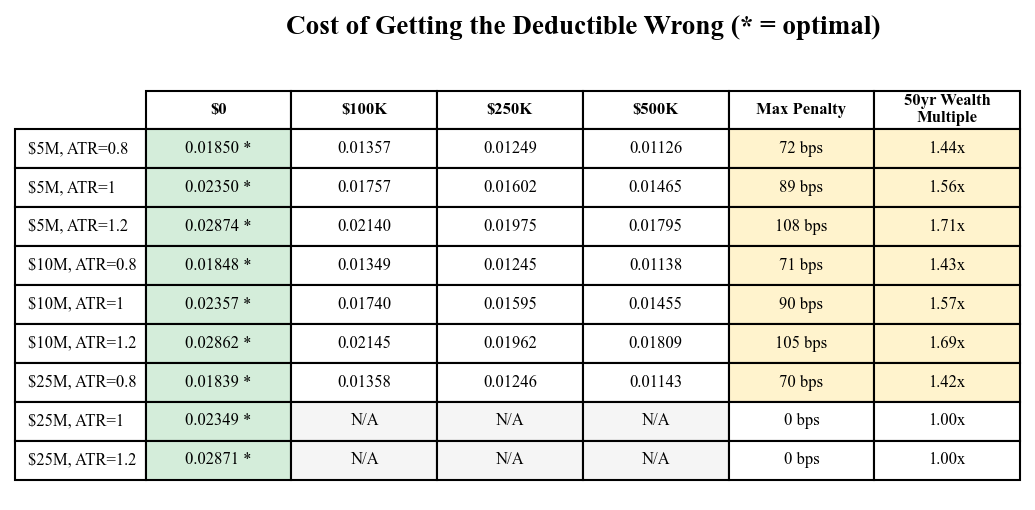

In [9]:
fig, ax = plt.subplots(figsize=(7.0, 3.5))
ax.axis('off')

# Build table data
row_labels = []
table_data = []
cell_colors = []

for cap in caps:
    for atr in atrs:
        row_labels.append(f'{fmt(cap)}, ATR={atr}')
        row_grs = []
        for ded in deds:
            k = find_key(cap, atr, ded=ded)
            row_grs.append(configs[k]['growth_rate_mean'] if k else np.nan)

        best_g = np.nanmax(row_grs)
        worst_g = np.nanmin(row_grs)
        penalty_bps = (best_g - worst_g) * 1e4
        wealth_mult = np.exp((best_g - worst_g) * 50)

        cells = []
        colors = []
        for g in row_grs:
            if np.isnan(g):
                cells.append('N/A')
                colors.append('#F5F5F5')
            elif abs(g - best_g) < 1e-8:
                cells.append(f'{g:.5f} *')
                colors.append('#D4EDDA')  # green highlight
            else:
                cells.append(f'{g:.5f}')
                colors.append('white')

        cells.append(f'{penalty_bps:.0f} bps')
        colors.append('#FFF3CD' if penalty_bps > 20 else 'white')
        cells.append(f'{wealth_mult:.2f}x')
        colors.append('#FFF3CD' if wealth_mult > 1.1 else 'white')
        table_data.append(cells)
        cell_colors.append(colors)

col_labels = [DED_LABELS[d] for d in deds] + ['Max Penalty', '50yr Wealth\nMultiple']

table = ax.table(
    cellText=table_data,
    rowLabels=row_labels,
    colLabels=col_labels,
    cellColours=cell_colors,
    loc='center',
    cellLoc='center',
)
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1, 1.5)

# Bold header row
for (row, col), cell in table.get_celld().items():
    if row == 0:
        cell.set_text_props(fontweight='bold', fontsize=8)
    if col == -1:
        cell.set_text_props(fontsize=8)

ax.set_title(
    'Cost of Getting the Deductible Wrong (* = optimal)',
    fontsize=13, fontweight='bold', pad=20,
)

fig.tight_layout()
save(fig, 'cost_of_getting_it_wrong')
plt.show()

## 11. Breakeven Time
Year at which the median insured path first exceeds the median uninsured path.
Under the exponential growth model, breakeven is immediate if median growth rate
is higher for insured; we report the growth rate differential instead.

Breakeven Analysis: Median Growth Rate Comparison
Config                            Insured  Uninsured   Diff (bps)          Status
--------------------------------------------------------------------------------
$5M, ATR=0.8, Ded=$0              0.01849    0.01115       73.4      Insured wins
$5M, ATR=0.8, Ded=$100K           0.01361    0.01115       24.6      Insured wins
$5M, ATR=0.8, Ded=$250K           0.01261    0.01115       14.6      Insured wins
$5M, ATR=0.8, Ded=$500K           0.01156    0.01115        4.1      Insured wins
$5M, ATR=1, Ded=$0                0.02348    0.01215      113.3      Insured wins
$5M, ATR=1, Ded=$100K             0.01762    0.01215       54.6      Insured wins
$5M, ATR=1, Ded=$250K             0.01615    0.01215       39.9      Insured wins
$5M, ATR=1, Ded=$500K             0.01495    0.01215       27.9      Insured wins
$5M, ATR=1.2, Ded=$0              0.02872    0.01388      148.4      Insured wins
$5M, ATR=1.2, Ded=$100K           0.02144    0.01

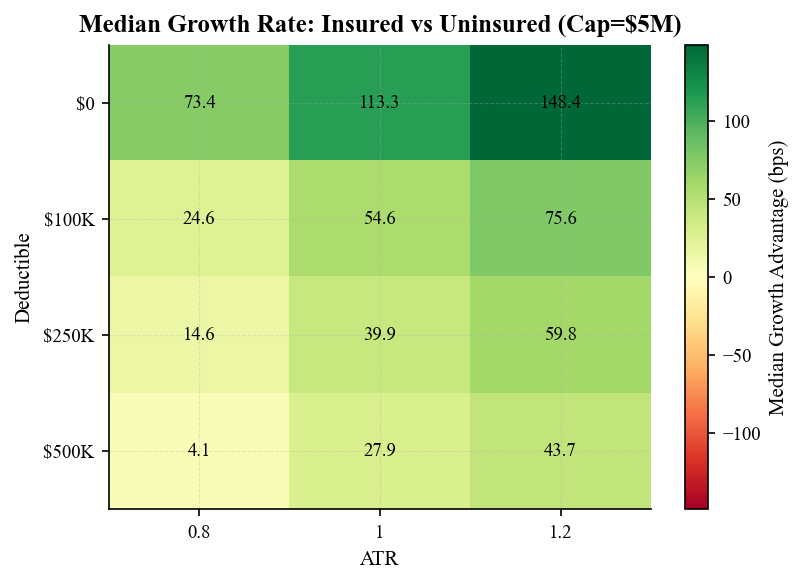

In [10]:
# Breakeven table: growth rate and median growth advantage
print('Breakeven Analysis: Median Growth Rate Comparison')
print('=' * 80)
print(f'{"Config":<30} {"Insured":>10} {"Uninsured":>10} {"Diff (bps)":>12} {"Status":>15}')
print('-' * 80)

breakeven_data = []
for cap in caps:
    for atr in atrs:
        k_ni = find_key(cap, atr, noins=True)
        if k_ni is None: continue
        g_ni_med = np.median(sim[k_ni]['gr'])
        for ded in deds:
            k_ins = find_key(cap, atr, ded=ded)
            if k_ins is None: continue
            g_ins_med = np.median(sim[k_ins]['gr'])
            diff_bps = (g_ins_med - g_ni_med) * 1e4
            status = 'Insured wins' if g_ins_med > g_ni_med else 'Uninsured wins'
            label = f'{fmt(cap)}, ATR={atr}, Ded={DED_LABELS[ded]}'
            print(f'{label:<30} {g_ins_med:>10.5f} {g_ni_med:>10.5f} {diff_bps:>10.1f}   {status:>15}')
            breakeven_data.append({
                'cap': cap, 'atr': atr, 'ded': ded,
                'g_ins': g_ins_med, 'g_ni': g_ni_med,
                'diff_bps': diff_bps,
            })

# Visualize as heatmap
fig, ax = plt.subplots(figsize=(5.5, 4.0))
# Pivot for $5M Cap
cap_focus = 5_000_000
sub = [d for d in breakeven_data if d['cap'] == cap_focus]
if sub:
    atrs_sub = sorted(set(d['atr'] for d in sub))
    deds_sub = sorted(set(d['ded'] for d in sub))
    matrix = np.full((len(deds_sub), len(atrs_sub)), np.nan)
    for d in sub:
        i = deds_sub.index(d['ded'])
        j = atrs_sub.index(d['atr'])
        matrix[i, j] = d['diff_bps']

    im = ax.imshow(matrix, cmap='RdYlGn', aspect='auto',
                   vmin=-max(abs(np.nanmin(matrix)), abs(np.nanmax(matrix))),
                   vmax=max(abs(np.nanmin(matrix)), abs(np.nanmax(matrix))))
    for i in range(len(deds_sub)):
        for j in range(len(atrs_sub)):
            if not np.isnan(matrix[i, j]):
                ax.text(j, i, f'{matrix[i,j]:.1f}', ha='center', va='center', fontsize=9)
    ax.set_xticks(range(len(atrs_sub)))
    ax.set_xticklabels([str(a) for a in atrs_sub])
    ax.set_yticks(range(len(deds_sub)))
    ax.set_yticklabels([DED_LABELS[d] for d in deds_sub])
    ax.set_xlabel('ATR')
    ax.set_ylabel('Deductible')
    plt.colorbar(im, ax=ax, label='Median Growth Advantage (bps)')

ax.set_title(
    f'Median Growth Rate: Insured vs Uninsured (Cap={fmt(cap_focus)})',
    fontsize=12, fontweight='bold',
)
fig.tight_layout()
save(fig, 'breakeven_growth_advantage')
plt.show()

## Summary
All publication figures saved to `output/publication/` at 300 DPI.

**GC Superiority Narrative (5 charts):**
1. Ensemble vs Time Average -- the ergodic gap flagship
2. Ranking Reversal -- slope chart + waterfall decomposition
3. Volatility Tax -- stochastic penalty by configuration
4. Sensitivity to Premium Loading -- crossover at 212% loading
5. Retained Loss Tail Risk -- box plots + exceedance curves

**Supporting Analysis (9 charts):**
6. Optimal Deductible Heatmap
7. Wealth Fan Chart
8. Survival Curves
9. Life/Death Attribution
10. Year-by-Year Growth Lift
11. Peer Benchmark
12. Insurance Outcome Distribution ($0 Ded vs No Insurance)
13. Cost of Getting It Wrong
14. Insurance Lift by Capitalization

In [11]:
# List all generated figures
figs = sorted(OUTPUT.glob('*.png'))
print(f'Generated {len(figs)} publication figures:')
for f in figs:
    size_kb = f.stat().st_size / 1024
    print(f'  {f.name:<45} {size_kb:>7.0f} KB')

Generated 13 publication figures:
  breakeven_growth_advantage.png                    115 KB
  cost_of_getting_it_wrong.png                      182 KB
  insurance_outcome_distribution.png                228 KB
  insurance_value_lift_with_scale.png               150 KB
  optimal_deductible_heatmap.png                    116 KB
  peer_benchmark_is_wrong.png                       117 KB
  ranking_reversal_decomposition.png                214 KB
  retained_loss_tail_risk.png                       205 KB
  sensitivity_premium_loading.png                   191 KB
  survival_curves.png                               121 KB
  volatility_tax_stochastic_penalty.png             146 KB
  wealth_fan_chart.png                              332 KB
  year_by_year_growth_lift.png                      147 KB


## 10. Insurance Lift Increases with Scale
Growth lift rises as capitalization increases; higher ATR (revenue intensity) amplifies the effect.

In [12]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
import numpy as np
import pickle
from pathlib import Path

# Publication rcParams (see VISUAL_SPECIFICATION.md)
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['CMU Serif', 'Computer Modern', 'Times New Roman', 'DejaVu Serif'],
    'font.size': 10, 'axes.titlesize': 11, 'axes.labelsize': 10,
    'xtick.labelsize': 9, 'ytick.labelsize': 9, 'legend.fontsize': 9,
    'legend.framealpha': 0.9, 'legend.edgecolor': '#CCCCCC',
    'figure.dpi': 150, 'savefig.dpi': 300,
    'savefig.bbox': 'tight', 'savefig.pad_inches': 0.1,
    'axes.spines.top': False, 'axes.spines.right': False,
    'axes.grid': True, 'axes.axisbelow': True,
    'grid.alpha': 0.3, 'grid.linestyle': '--', 'grid.linewidth': 0.5,
    'text.usetex': False, 'mathtext.fontset': 'cm',
})

PAL = {
    'blue': '#0072B2', 'orange': '#E69F00', 'green': '#009E73',
    'vermillion': '#D55E00', 'purple': '#CC79A7', 'sky': '#56B4E9',
    'yellow': '#F0E442', 'gray': '#999999', 'dark': '#333333',
}
DED_COLORS = {0: PAL['blue'], 100_000: PAL['sky'], 250_000: PAL['orange'], 500_000: PAL['vermillion']}
DED_LABELS = {0: '$0', 100_000: '$100K', 250_000: '$250K', 500_000: '$500K'}
DED_COLORS_EXT = {**DED_COLORS, 'noins': PAL['gray']}
DED_LABELS_EXT = {**DED_LABELS, 'noins': 'No Insurance'}
LW_EM, LW_STD, LW_REF, LW_THIN = 2.5, 1.5, 1.0, 0.3

OUTPUT = Path('output/publication')
OUTPUT.mkdir(parents=True, exist_ok=True)

def fmt(n):
    if abs(n) >= 1e9: return f'${n/1e9:.0f}B'
    if abs(n) >= 1e6: return f'${n/1e6:.0f}M'
    if abs(n) >= 1e3: return f'${n/1e3:.0f}K'
    return f'${n:.0f}'

def save(fig, name):
    p = OUTPUT / f'{name}.png'
    fig.savefig(p, dpi=300, facecolor='white')
    print(f'Saved: {p}')

DECOMP = {
    '$0K':    {'g_naive': 382.9, 'g_det': 212.7, 'g_actual': 235.0, 'tax_drag': 170.2, 'stoch_pen': -22.3},
    '$100K':  {'g_naive': 412.0, 'g_det': 229.3, 'g_actual': 175.7, 'tax_drag': 182.7, 'stoch_pen':  53.6},
    '$250K':  {'g_naive': 418.3, 'g_det': 232.9, 'g_actual': 160.2, 'tax_drag': 185.4, 'stoch_pen':  72.7},
    '$500K':  {'g_naive': 423.9, 'g_det': 236.1, 'g_actual': 146.5, 'tax_drag': 187.8, 'stoch_pen':  89.6},
    'No Ins': {'g_naive': 464.9, 'g_det': 259.6, 'g_actual': 123.5, 'tax_drag': 205.3, 'stoch_pen': 136.1},
}

RETAINED_VOL = {
    '$0K': {'std_pct': 0.00, 'max_pct': 0.00},
    '$100K': {'std_pct': 1.25, 'max_pct': 10.49},
    '$250K': {'std_pct': 1.85, 'max_pct': 20.51},
    '$500K': {'std_pct': 2.66, 'max_pct': 34.49},
    'No Ins': {'std_pct': 19.93, 'max_pct': 1429.44},
}

PRICING = {
    'EBITABL': 0.125, 'tax_rate': 0.25, 'retention_ratio': 0.70, 'base_LR': 0.70,
    'expected_losses': {'$0K': 182_264, '$100K': 117_529, '$250K': 103_500, '$500K': 91_125},
    'expected_retained': {'$0K': 0, '$100K': 64_734, '$250K': 78_763, '$500K': 91_139},
    'revenue': 5_000_000,
}
print("Cell 1 setup complete.")

Cell 1 setup complete.


In [13]:
import gc

with open('cache/dashboard_cache.pkl', 'rb') as f:
    cache = pickle.load(f)
configs = cache['configs']
crn_pairs = cache['crn_pairs']
param_values = cache['param_values']
RESULTS_DIR = Path(cache['results_dir'])

def find_key(cap, atr, ded=None, noins=False):
    for k, c in configs.items():
        if c['Cap'] == cap and c['ATR'] == atr:
            if noins and c.get('NOINS'): return k
            if not noins and not c.get('NOINS') and c.get('Ded') == ded: return k
    return None

def ruin_val(cfg, yr):
    rp = cfg['ruin_probability']
    for k, v in rp.items():
        if int(k) == yr: return v
    return None

def get_per_sim_ruin(key, min_trailing=2):
    path = RESULTS_DIR / f'{key}.pkl'
    with open(path, 'rb') as f:
        data = pickle.load(f)
    losses = data.annual_losses
    n_sims, n_years = losses.shape
    last_active = np.full(n_sims, -1, dtype=int)
    for yr in range(n_years - 1, -1, -1):
        active = (losses[:, yr] != 0) & (last_active == -1)
        last_active[active] = yr
    ruined = last_active < (n_years - min_trailing)
    del data
    gc.collect()
    return ruined

sim = {}
def load_sim(key):
    if key in sim: return sim[key]
    path = RESULTS_DIR / f'{key}.pkl'
    with open(path, 'rb') as f:
        data = pickle.load(f)
    sim[key] = {'gr': data.growth_rates.copy(), 'fa': data.final_assets.copy()}
    del data
    return sim[key]

print('Loading simulation arrays...')
for cap in param_values['Cap']:
    for atr in param_values['ATR']:
        k = find_key(cap, atr, noins=True)
        if k: load_sim(k)
        for ded in param_values['Ded']:
            k = find_key(cap, atr, ded=ded)
            if k: load_sim(k)
deds = param_values['Ded']
caps = param_values['Cap']
atrs = param_values['ATR']
print(f'Loaded {len(sim)} configs')

Loading simulation arrays...
Loaded 37 configs


Saved: output\publication\ranking_reversal_decomposition.png


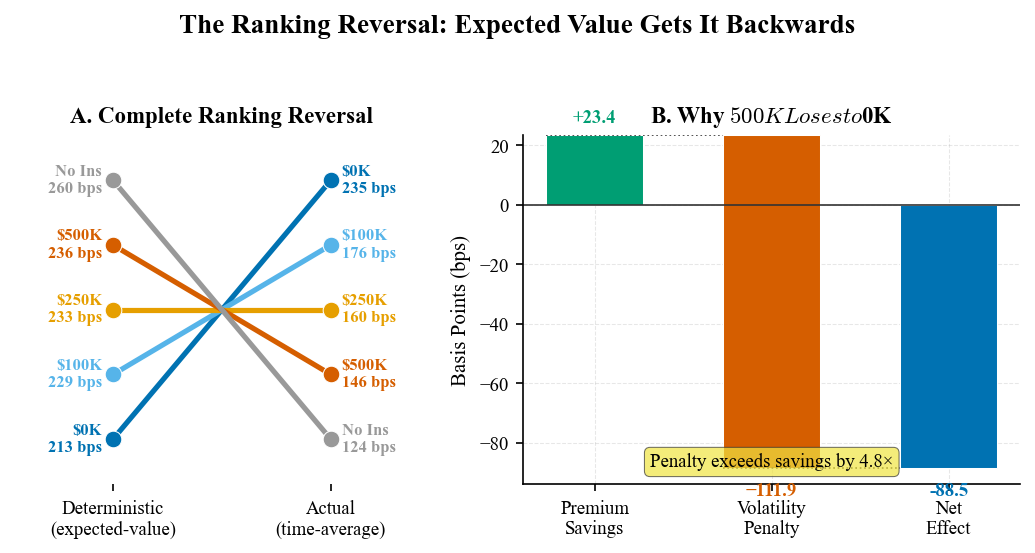

In [14]:
# === The Ranking Reversal: Slope Chart + Waterfall ===
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7.0, 3.5),
                                gridspec_kw={'width_ratios': [1, 1.2]})

# --- Panel A: Slope Chart ---
configs_list = ['$0K', '$100K', '$250K', '$500K', 'No Ins']
colors_slope = [PAL['blue'], PAL['sky'], PAL['orange'], PAL['vermillion'], PAL['gray']]
g_det = np.array([DECOMP[c]['g_det'] for c in configs_list])
g_actual = np.array([DECOMP[c]['g_actual'] for c in configs_list])

# Rank: 1 = best (highest growth rate)
det_rank = len(g_det) - np.argsort(np.argsort(g_det))
actual_rank = len(g_actual) - np.argsort(np.argsort(g_actual))

for i, (label, color) in enumerate(zip(configs_list, colors_slope)):
    ax1.plot([0, 1], [det_rank[i], actual_rank[i]], color=color,
             lw=LW_EM, marker='o', ms=8, markerfacecolor=color,
             markeredgecolor='white', markeredgewidth=0.5, zorder=3)
    # Left labels (deterministic ranking)
    ax1.text(-0.05, det_rank[i], f'{label}\n{g_det[i]:.0f} bps',
             ha='right', va='center', fontsize=8, color=color, fontweight='bold')
    # Right labels (actual ranking)
    ax1.text(1.05, actual_rank[i], f'{label}\n{g_actual[i]:.0f} bps',
             ha='left', va='center', fontsize=8, color=color, fontweight='bold')

ax1.set_xlim(-0.45, 1.45)
ax1.set_ylim(0.3, 5.7)
ax1.invert_yaxis()
ax1.set_xticks([0, 1])
ax1.set_xticklabels(['Deterministic\n(expected-value)', 'Actual\n(time-average)'], fontsize=9)
ax1.set_yticks([])
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.grid(False)
ax1.set_title('A. Complete Ranking Reversal', fontsize=11, fontweight='bold')

# --- Panel B: Waterfall: $500K vs $0K ---
det_advantage = DECOMP['$500K']['g_det'] - DECOMP['$0K']['g_det']   # +23.4
pen_swing = DECOMP['$500K']['stoch_pen'] - DECOMP['$0K']['stoch_pen']  # 111.9
net_effect = det_advantage - pen_swing  # -88.5

labels_wf = ['Premium\nSavings', 'Volatility\nPenalty', 'Net\nEffect']
x_wf = np.arange(3)

# Bar 1: Premium savings (positive, green, from 0 to +23.4)
ax2.bar(x_wf[0], det_advantage, bottom=0, color=PAL['green'],
        edgecolor='white', lw=0.5, width=0.55)
ax2.text(x_wf[0], det_advantage + 3, f'+{det_advantage:.1f}',
         ha='center', va='bottom', fontsize=9, fontweight='bold', color=PAL['green'])

# Bar 2: Volatility penalty (negative, drops from +23.4 to net_effect)
ax2.bar(x_wf[1], -pen_swing, bottom=det_advantage, color=PAL['vermillion'],
        edgecolor='white', lw=0.5, width=0.55)
ax2.text(x_wf[1], net_effect - 5, f'\u2212{pen_swing:.1f}',
         ha='center', va='top', fontsize=9, fontweight='bold', color=PAL['vermillion'])

# Bar 3: Net effect (summary bar from 0 to net_effect)
ax2.bar(x_wf[2], net_effect, bottom=0, color=PAL['blue'],
        edgecolor='white', lw=0.5, width=0.55)
ax2.text(x_wf[2], net_effect - 5, f'{net_effect:.1f}',
         ha='center', va='top', fontsize=9, fontweight='bold', color=PAL['blue'])

# Connector lines
ax2.plot([x_wf[0] - 0.275, x_wf[0] + 0.275], [det_advantage, det_advantage],
         color=PAL['dark'], lw=0.8, ls=':')
ax2.plot([x_wf[0] + 0.275, x_wf[1] - 0.275], [det_advantage, det_advantage],
         color=PAL['dark'], lw=0.8, ls=':')
ax2.plot([x_wf[1] - 0.275, x_wf[1] + 0.275], [net_effect, net_effect],
         color=PAL['dark'], lw=0.8, ls=':')
ax2.plot([x_wf[1] + 0.275, x_wf[2] - 0.275], [net_effect, net_effect],
         color=PAL['dark'], lw=0.8, ls=':')

ax2.axhline(0, color=PAL['dark'], lw=0.8)
ax2.set_xticks(x_wf)
ax2.set_xticklabels(labels_wf, fontsize=9)
ax2.set_ylabel('Basis Points (bps)')
ax2.set_title('B. Why $500K Loses to $0K', fontsize=11, fontweight='bold')

# Annotation: penalty exceeds savings
ax2.text(0.5, 0.05, f'Penalty exceeds savings by {pen_swing/det_advantage:.1f}\u00d7',
         transform=ax2.transAxes, fontsize=9, ha='center',
         bbox=dict(boxstyle='round,pad=0.3', fc=PAL['yellow'], alpha=0.7,
                   ec=PAL['dark'], lw=0.5))

fig.suptitle('The Ranking Reversal: Expected Value Gets It Backwards',
             fontsize=13, fontweight='bold', y=1.04)
fig.tight_layout()
save(fig, 'ranking_reversal_decomposition')
plt.show()

Saved: output\publication\volatility_tax_stochastic_penalty.png


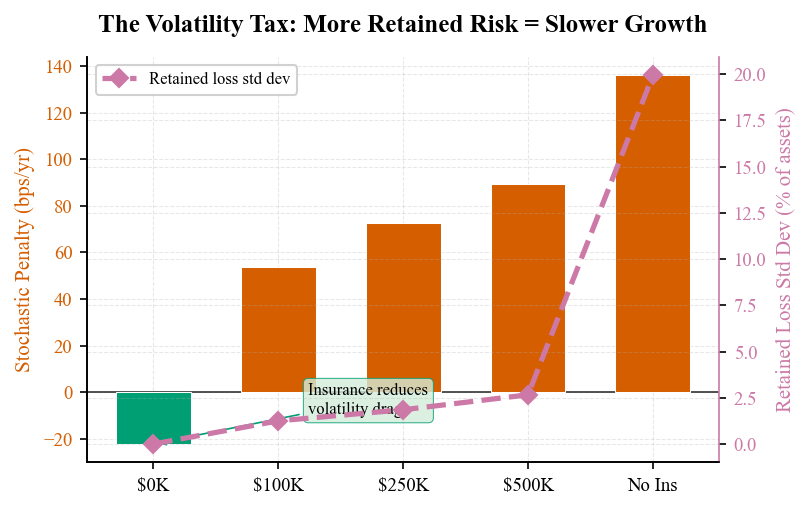

In [15]:
# === The Volatility Tax: Stochastic Penalty by Configuration ===
configs_vt = ['\\$0K', '\\$100K', '\\$250K', '\\$500K', 'No Ins']
configs_keys = ['$0K', '$100K', '$250K', '$500K', 'No Ins']
stoch_pens = [DECOMP[c]['stoch_pen'] for c in configs_keys]
ret_stds = [RETAINED_VOL[c]['std_pct'] for c in configs_keys]

fig, ax1 = plt.subplots(figsize=(5.5, 3.5))
x = np.arange(len(configs_vt))

# Bar colors: green for negative penalty ($0K), vermillion for positive
bar_colors = [PAL['green'] if sp <= 0 else PAL['vermillion'] for sp in stoch_pens]
bars = ax1.bar(x, stoch_pens, color=bar_colors, edgecolor='white', lw=0.5, width=0.6,
               zorder=3)

# Value labels on bars
for xi, sp in enumerate(stoch_pens):
    va = 'top' if sp > 0 else 'bottom'
    offset = -4 if sp > 0 else 4
    ax1.text(xi, sp + offset, f'{sp:+.1f}', ha='center', va=va,
             fontsize=9, fontweight='bold', color=bar_colors[xi])

ax1.axhline(0, color=PAL['dark'], lw=0.8)
ax1.set_xticks(x)
ax1.set_xticklabels(configs_vt, fontsize=9)
ax1.set_ylabel('Stochastic Penalty (bps/yr)', color=PAL['vermillion'])
ax1.tick_params(axis='y', labelcolor=PAL['vermillion'])

# Secondary y-axis: retained loss std dev
ax2 = ax1.twinx()
ax2.plot(x, ret_stds, color=PAL['purple'], lw=LW_EM, ls='--',
         marker='D', ms=6, label='Retained loss std dev', zorder=4)
ax2.set_ylabel('Retained Loss Std Dev (% of assets)', color=PAL['purple'])
ax2.tick_params(axis='y', labelcolor=PAL['purple'])
ax2.spines['right'].set_visible(True)
ax2.spines['right'].set_color(PAL['purple'])

# Annotation on $0K bar - use axes fraction coords to avoid overlap
ax1.annotate(
    'Insurance reduces\nvolatility drag',
    xy=(0, stoch_pens[0]),
    xytext=(0.35, 0.12),
    textcoords='axes fraction',
    fontsize=8,
    arrowprops=dict(arrowstyle='->', color=PAL['green'], lw=0.8),
    bbox=dict(boxstyle='round,pad=0.3', fc='#D4EDDA', alpha=0.8,
              ec=PAL['green'], lw=0.5),
)

ax1.set_title('The Volatility Tax: More Retained Risk = Slower Growth',
              fontsize=12, fontweight='bold', pad=12)

# Legend for the line
ax2.legend(loc='upper left', fontsize=8)

fig.tight_layout()
save(fig, 'volatility_tax_stochastic_penalty')
plt.show()

Crossover: LR=0.321, loading=212%
Saved: output\publication\sensitivity_premium_loading.png


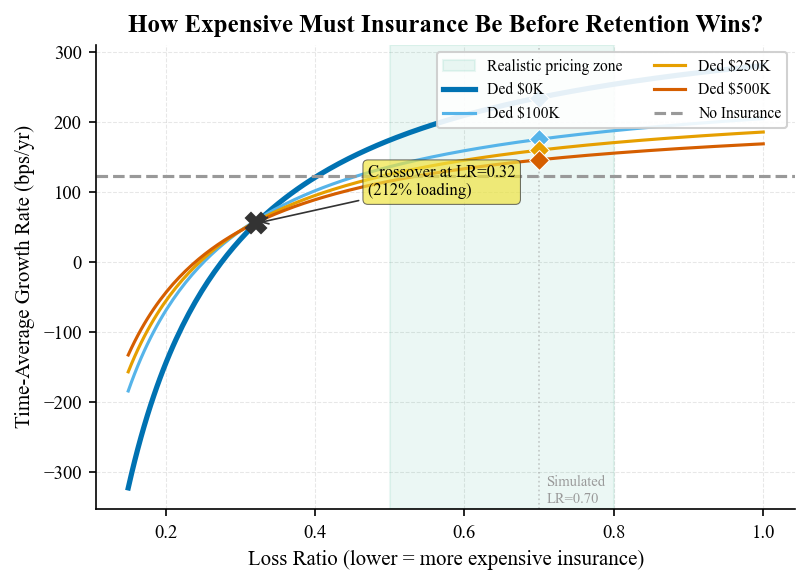

In [16]:
P = PRICING
tax_ratio = 0.557
lr_range = np.linspace(0.15, 1.0, 200)

def g_actual_fn(label, lr):
    e_ins = P['expected_losses'][label]
    e_ret = P['expected_retained'][label]
    sp = DECOMP[label]['stoch_pen']
    g_naive = (P['EBITABL'] - (e_ins / lr + e_ret) / P['revenue']) \
              * (1 - P['tax_rate']) * P['retention_ratio'] * 10000
    return g_naive * tax_ratio - sp

fig, ax = plt.subplots(figsize=(5.5, 4.0))
ax.axvspan(0.50, 0.80, color=PAL['green'], alpha=0.08, label='Realistic pricing zone')

ded_configs = [
    ('$0K', PAL['blue'], '-', LW_EM),
    ('$100K', PAL['sky'], '-', LW_STD),
    ('$250K', PAL['orange'], '-', LW_STD),
    ('$500K', PAL['vermillion'], '-', LW_STD),
]

for label, color, ls, lw in ded_configs:
    g_vals = np.array([g_actual_fn(label, lr) for lr in lr_range])
    ax.plot(lr_range, g_vals, color=color, lw=lw, ls=ls, label=f'Ded {label}')
    g_sim = DECOMP[label]['g_actual']
    ax.plot(0.70, g_sim, marker='D', ms=7, color=color, markeredgecolor='white',
            markeredgewidth=0.5, zorder=5)

g_noins = DECOMP['No Ins']['g_actual']
ax.axhline(g_noins, color=PAL['gray'], lw=LW_STD, ls='--', label='No Insurance')

# Find crossover: iterate from HIGH LR down to find where $500K first beats $0K
for lr_test in reversed(lr_range):
    g0 = g_actual_fn('$0K', lr_test)
    g5 = g_actual_fn('$500K', lr_test)
    if g5 >= g0:
        crossover_lr = lr_test
        crossover_g = g0
        loading_pct = (1/lr_test - 1) * 100
        ax.plot(crossover_lr, crossover_g, 'X', ms=10, color=PAL['dark'], zorder=6)
        ax.annotate(
            f'Crossover at LR={crossover_lr:.2f}\n({loading_pct:.0f}% loading)',
            xy=(crossover_lr, crossover_g),
            xytext=(crossover_lr + 0.15, crossover_g + 40),
            fontsize=8,
            arrowprops=dict(arrowstyle='->', color=PAL['dark'], lw=0.8),
            bbox=dict(boxstyle='round,pad=0.3', fc=PAL['yellow'], alpha=0.7,
                      ec=PAL['dark'], lw=0.5),
        )
        print(f'Crossover: LR={crossover_lr:.3f}, loading={loading_pct:.0f}%')
        break

ax.axvline(0.70, color=PAL['gray'], ls=':', lw=0.8, alpha=0.5)
ax.text(0.71, ax.get_ylim()[0] + 5, 'Simulated\nLR=0.70', fontsize=7,
        color=PAL['gray'], va='bottom')

ax.set_xlabel('Loss Ratio (lower = more expensive insurance)')
ax.set_ylabel('Time-Average Growth Rate (bps/yr)')
ax.set_title('How Expensive Must Insurance Be Before Retention Wins?',
             fontsize=12, fontweight='bold')
ax.legend(loc='upper right', fontsize=7.5, ncol=2)

fig.tight_layout()
save(fig, 'sensitivity_premium_loading')
plt.show()

In [17]:
# === Retained Loss Tail Risk ===
N_YEARS_SIM = 100_000
A0 = 5_000_000
revenue = 5_000_000
rng_loss = np.random.default_rng(42)

# Loss distribution params
att_freq = 2.85 * revenue / 10_000_000
att_cv = 0.8
att_sigma = np.sqrt(np.log(1 + att_cv**2))
att_mu = np.log(40_000) - att_sigma**2 / 2

lg_freq = 0.20 * revenue / 10_000_000
lg_cv = 1.5
lg_sigma = np.sqrt(np.log(1 + lg_cv**2))
lg_mu = np.log(500_000) - lg_sigma**2 / 2

cat_freq = 0.02 * revenue / 10_000_000
cat_xm = 5_000_000
cat_alpha = 2.5

deductibles_sim = {'\\$0K': 0, '\\$100K': 100_000, '\\$250K': 250_000,
               '\\$500K': 500_000, 'No Ins': np.inf}
retained_annual = {k: np.zeros(N_YEARS_SIM) for k in deductibles_sim}

for yr in range(N_YEARS_SIM):
    year_losses = []
    n_att = rng_loss.poisson(att_freq)
    if n_att > 0:
        year_losses.extend(rng_loss.lognormal(att_mu, att_sigma, n_att).tolist())
    n_lg = rng_loss.poisson(lg_freq)
    if n_lg > 0:
        year_losses.extend(rng_loss.lognormal(lg_mu, lg_sigma, n_lg).tolist())
    n_cat = rng_loss.poisson(cat_freq)
    if n_cat > 0:
        u = rng_loss.uniform(0, 1, n_cat)
        cat_losses = cat_xm * u ** (-1 / cat_alpha)
        year_losses.extend(cat_losses.tolist())
    for label, ded in deductibles_sim.items():
        total_retained = 0.0
        for loss in year_losses:
            if ded == np.inf:
                total_retained += loss
            else:
                total_retained += min(loss, ded)
        retained_annual[label][yr] = total_retained

retained_pct = {k: v / A0 * 100 for k, v in retained_annual.items()}
print("Annual retained losses (% of assets):")
for label in deductibles_sim:
    vals = retained_pct[label]
    print(f"  {label:>8}: mean={vals.mean():.2f}%, std={vals.std():.2f}%, "
          f"max={vals.max():.1f}%, P99={np.percentile(vals, 99):.2f}%")

Annual retained losses (% of assets):
      \$0K: mean=0.00%, std=0.00%, max=0.0%, P99=0.00%
    \$100K: mean=1.28%, std=1.25%, max=11.0%, P99=5.19%
    \$250K: mean=1.57%, std=1.85%, max=18.1%, P99=7.92%
    \$500K: mean=1.82%, std=2.66%, max=29.4%, P99=12.12%
    No Ins: mean=3.74%, std=21.32%, max=1955.0%, P99=96.32%


Saved: output\publication\retained_loss_tail_risk.png


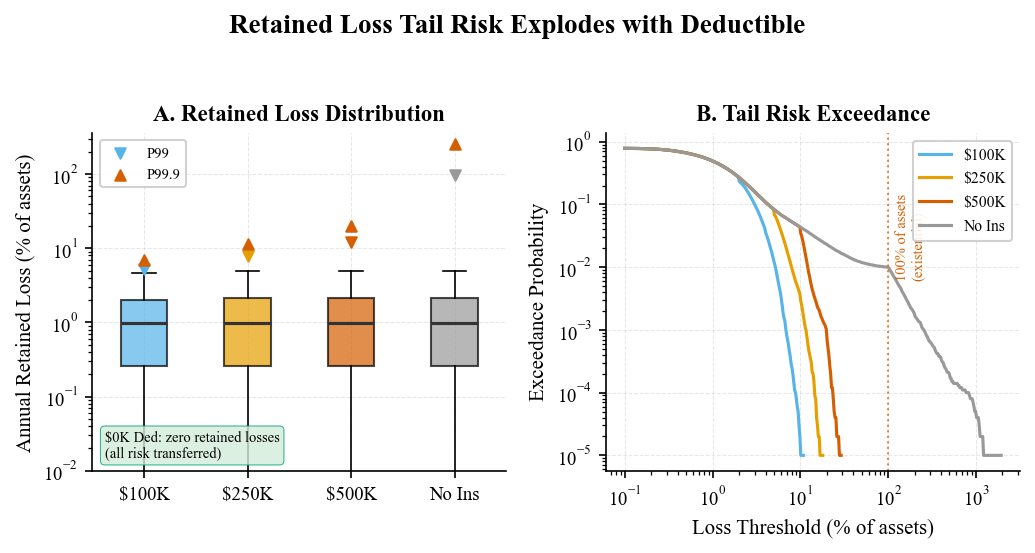

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7.0, 3.5))

ded_keys_box = ['\\$100K', '\\$250K', '\\$500K', 'No Ins']
ded_colors_box = [PAL['sky'], PAL['orange'], PAL['vermillion'], PAL['gray']]
data_box = [retained_pct[k] for k in ded_keys_box]

bp = ax1.boxplot(data_box, tick_labels=ded_keys_box, patch_artist=True, showfliers=False,
                 whiskerprops=dict(lw=0.8), capprops=dict(lw=0.8),
                 medianprops=dict(color=PAL['dark'], lw=1.5))
for patch, color in zip(bp['boxes'], ded_colors_box):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

for i, k in enumerate(ded_keys_box):
    p99 = np.percentile(retained_pct[k], 99)
    p999 = np.percentile(retained_pct[k], 99.9)
    if p99 > 0:
        ax1.scatter(i + 1, p99, marker='v', s=25, color=ded_colors_box[i],
                    zorder=5, label='P99' if i == 0 else None)
    if p999 > 0 and p999 > p99 * 1.2:
        ax1.scatter(i + 1, p999, marker='^', s=25, color=PAL['vermillion'],
                    zorder=5, label='P99.9' if i == 0 else None)

ax1.set_yscale('log')
ax1.set_ylim(0.01, None)
ax1.set_ylabel('Annual Retained Loss (% of assets)')
ax1.set_title('A. Retained Loss Distribution', fontsize=11, fontweight='bold')

ax1.text(0.03, 0.03, '\\$0K Ded: zero retained losses\n(all risk transferred)',
         transform=ax1.transAxes, fontsize=7, va='bottom',
         bbox=dict(boxstyle='round,pad=0.3', fc='#D4EDDA', alpha=0.8,
                   ec=PAL['green'], lw=0.5))

noins_max = retained_pct['No Ins'].max()
ax1.annotate(f'Max: {noins_max:.0f}%', xy=(4, noins_max),
             xytext=(3.0, noins_max * 0.25),
             fontsize=7, arrowprops=dict(arrowstyle='->', lw=0.6, color=PAL['dark']),
             bbox=dict(boxstyle='round,pad=0.2', fc='white', ec=PAL['gray'], lw=0.5))
ax1.legend(fontsize=7, loc='upper left')

# Panel B
ded_keys_all = ['\\$0K', '\\$100K', '\\$250K', '\\$500K', 'No Ins']
ded_colors_all = [PAL['blue'], PAL['sky'], PAL['orange'], PAL['vermillion'], PAL['gray']]
thresholds = np.logspace(-1, 4, 500)

for i, k in enumerate(ded_keys_all):
    if k == '\\$0K': continue
    vals = retained_pct[k]
    exceed = np.array([np.mean(vals > t) for t in thresholds])
    valid = exceed > 0
    if valid.sum() > 0:
        ax2.plot(thresholds[valid], exceed[valid], color=ded_colors_all[i],
                 lw=LW_STD, label=k)

ax2.axvline(100, color=PAL['vermillion'], ls=':', lw=LW_REF, alpha=0.7)
ax2.text(120, 0.15, '100% of assets\n(existential)', fontsize=7,
         color=PAL['vermillion'], va='top', rotation=90)

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('Loss Threshold (% of assets)')
ax2.set_ylabel('Exceedance Probability')
ax2.set_title('B. Tail Risk Exceedance', fontsize=11, fontweight='bold')
ax2.legend(fontsize=7.5, loc='upper right')

fig.suptitle('Retained Loss Tail Risk Explodes with Deductible',
             fontsize=13, fontweight='bold', y=1.04)
fig.tight_layout()
save(fig, 'retained_loss_tail_risk')
plt.show()

Saved: output\publication\insurance_value_lift_with_scale.png


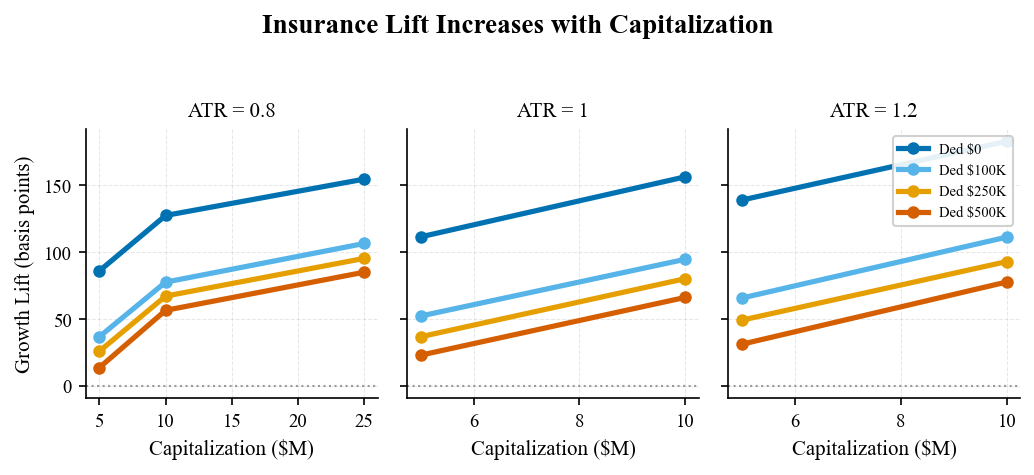

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(7.0, 3.0), sharey=True)

for ax_idx, atr in enumerate(atrs):
    ax = axes[ax_idx]
    for ded in deds:
        cap_vals = []
        lift_vals = []
        for cap in caps:
            k_ins = find_key(cap, atr, ded=ded)
            k_ni = find_key(cap, atr, noins=True)
            if k_ins and k_ni:
                g_ins = configs[k_ins]['growth_rate_mean']
                g_ni = configs[k_ni]['growth_rate_mean']
                cap_vals.append(cap / 1e6)
                lift_vals.append((g_ins - g_ni) * 1e4)  # basis points
        if cap_vals:
            ax.plot(cap_vals, lift_vals, color=DED_COLORS[ded], lw=LW_EM,
                    marker='o', ms=5, label=f'Ded {DED_LABELS[ded]}')

    ax.axhline(0, color=PAL['gray'], ls=':', lw=LW_REF)
    ax.set_title(f'ATR = {atr}', fontsize=10)
    ax.set_xlabel('Capitalization ($M)')
    if ax_idx == 0:
        ax.set_ylabel('Growth Lift (basis points)')
    if ax_idx == 2:
        ax.legend(fontsize=7, loc='upper right')

fig.suptitle(
    'Insurance Lift Increases with Capitalization',
    fontsize=13, fontweight='bold', y=1.04,
)
fig.tight_layout()
save(fig, 'insurance_value_lift_with_scale')
plt.show()

In [20]:
# List all generated figures
figs = sorted(OUTPUT.glob('*.png'))
print(f'Generated {len(figs)} publication figures:')
for f in figs:
    size_kb = f.stat().st_size / 1024
    print(f'  {f.name:<45} {size_kb:>7.0f} KB')

Generated 13 publication figures:
  breakeven_growth_advantage.png                    115 KB
  cost_of_getting_it_wrong.png                      182 KB
  insurance_outcome_distribution.png                228 KB
  insurance_value_lift_with_scale.png               150 KB
  optimal_deductible_heatmap.png                    116 KB
  peer_benchmark_is_wrong.png                       117 KB
  ranking_reversal_decomposition.png                214 KB
  retained_loss_tail_risk.png                       205 KB
  sensitivity_premium_loading.png                   191 KB
  survival_curves.png                               121 KB
  volatility_tax_stochastic_penalty.png             146 KB
  wealth_fan_chart.png                              332 KB
  year_by_year_growth_lift.png                      147 KB


In [21]:
figs = sorted(OUTPUT.glob('*.png'))
print(f'Generated {len(figs)} publication figures:')
for f in figs:
    size_kb = f.stat().st_size / 1024
    print(f'  {f.name:<45} {size_kb:>7.0f} KB')

Generated 13 publication figures:
  breakeven_growth_advantage.png                    115 KB
  cost_of_getting_it_wrong.png                      182 KB
  insurance_outcome_distribution.png                228 KB
  insurance_value_lift_with_scale.png               150 KB
  optimal_deductible_heatmap.png                    116 KB
  peer_benchmark_is_wrong.png                       117 KB
  ranking_reversal_decomposition.png                214 KB
  retained_loss_tail_risk.png                       205 KB
  sensitivity_premium_loading.png                   191 KB
  survival_curves.png                               121 KB
  volatility_tax_stochastic_penalty.png             146 KB
  wealth_fan_chart.png                              332 KB
  year_by_year_growth_lift.png                      147 KB


In [22]:
# Investigate the growth rate distribution for No Insurance
CAP, ATR = 5_000_000, 1.0
k_ni = find_key(CAP, ATR, noins=True)

gr = sim[k_ni]['gr']
fa = sim[k_ni]['fa']
ruined = get_per_sim_ruin(k_ni)

print(f"No Insurance, Cap=$5M, ATR=1.0")
print(f"Total paths: {len(gr):,}")
print(f"Ruined paths (from trailing-zeros detection): {ruined.sum():,} ({ruined.mean():.1%})")
print(f"Ruin prob from cache: {ruin_val(configs[k_ni], 50):.1%}")
print()
print(f"Growth rates (ALL paths):")
print(f"  min={gr.min():.6f}, P1={np.percentile(gr, 1):.6f}, P5={np.percentile(gr, 5):.6f}")
print(f"  P10={np.percentile(gr, 10):.6f}, P25={np.percentile(gr, 25):.6f}")
print(f"  median={np.median(gr):.6f}, mean={gr.mean():.6f}")
print()
print(f"Growth rates (RUINED paths only):")
gr_ruined = gr[ruined]
if len(gr_ruined) > 0:
    print(f"  min={gr_ruined.min():.6f}, P5={np.percentile(gr_ruined, 5):.6f}")
    print(f"  median={np.median(gr_ruined):.6f}, mean={gr_ruined.mean():.6f}")
    print(f"  max={gr_ruined.max():.6f}")
print()
print(f"Growth rates (SURVIVING paths only):")
gr_surv = gr[~ruined]
print(f"  min={gr_surv.min():.6f}, median={np.median(gr_surv):.6f}, mean={gr_surv.mean():.6f}")
print()
print(f"Final assets (RUINED paths):")
fa_ruined = fa[ruined]
if len(fa_ruined) > 0:
    print(f"  min=${fa_ruined.min():,.0f}, median=${np.median(fa_ruined):,.0f}, max=${fa_ruined.max():,.0f}")
    print(f"  mean=${fa_ruined.mean():,.0f}")
    print(f"  Fraction with fa > $10K: {(fa_ruined > 10_000).mean():.1%}")
    print(f"  Fraction with fa > $100K: {(fa_ruined > 100_000).mean():.1%}")
    print(f"  Fraction with fa > $1M: {(fa_ruined > 1_000_000).mean():.1%}")
print()
print(f"Final assets (SURVIVING paths):")
fa_surv = fa[~ruined]
print(f"  min=${fa_surv.min():,.0f}, median=${np.median(fa_surv):,.0f}")

No Insurance, Cap=$5M, ATR=1.0
Total paths: 250,000
Ruined paths (from trailing-zeros detection): 94,621 (37.8%)
Ruin prob from cache: 38.2%

Growth rates (ALL paths):
  min=-0.032269, P1=-0.010066, P5=-0.002905
  P10=0.000375, P25=0.005519
  median=0.012154, mean=0.012350

Growth rates (RUINED paths only):
  min=-0.032269, P5=-0.004755
  median=0.007331, mean=0.007429
  max=0.029047

Growth rates (SURVIVING paths only):
  min=-0.028741, median=0.017415, mean=0.015347

Final assets (RUINED paths):
  min=$996,009, median=$7,213,918, max=$21,365,350
  mean=$7,666,620
  Fraction with fa > $10K: 100.0%
  Fraction with fa > $100K: 100.0%
  Fraction with fa > $1M: 100.0%

Final assets (SURVIVING paths):
  min=$1,188,136, median=$11,943,737


In [23]:
# The growth_rate field is log(final_assets/initial_assets)/n_years
# So ruined paths get a POSITIVE growth rate because final_assets > initial_assets
# even though the company is insolvent

A0 = 5_000_000
print("Ruined path growth rates imply these final asset values:")
print(f"  Median ruined gr = {np.median(gr_ruined):.6f}")
print(f"  -> A0 * exp(g * 50) = ${A0 * np.exp(np.median(gr_ruined) * 50):,.0f}")
print(f"  Actual median ruined final_assets = ${np.median(fa_ruined):,.0f}")
print()

# The fan chart uses growth_rates to reconstruct paths as smooth exponentials.
# Since ruined paths have POSITIVE growth rates (median 73 bps/yr),
# they plot as gently rising curves — indistinguishable from survivors.
# The ruin event is invisible in the growth_rate representation.

print("Key insight:")
print(f"  Ruined paths median growth rate: {np.median(gr_ruined)*1e4:.1f} bps/yr")
print(f"  Surviving paths median growth rate: {np.median(gr_surv)*1e4:.1f} bps/yr")
print(f"  The distributions OVERLAP heavily.")
print()

# What percentile of ALL paths would you need to go to before seeing ruin-like trajectories?
# Since even the worst ruined path has gr=-0.032, the implied final assets are:
worst_fa = A0 * np.exp(gr.min() * 50)
print(f"  Worst growth rate: {gr.min():.6f} -> final assets ${worst_fa:,.0f}")
print(f"  Ruin threshold on chart: $10,000")
print(f"  Even the WORST path ends at ${worst_fa:,.0f} — 100x above the chart's ruin line")

Ruined path growth rates imply these final asset values:
  Median ruined gr = 0.007331
  -> A0 * exp(g * 50) = $7,213,918
  Actual median ruined final_assets = $7,213,918

Key insight:
  Ruined paths median growth rate: 73.3 bps/yr
  Surviving paths median growth rate: 174.2 bps/yr
  The distributions OVERLAP heavily.

  Worst growth rate: -0.032269 -> final assets $996,009
  Ruin threshold on chart: $10,000
  Even the WORST path ends at $996,009 — 100x above the chart's ruin line


In [24]:
# Check what fields are stored in SimulationResults
k_ni = find_key(5_000_000, 1.0, noins=True)
path = RESULTS_DIR / f'{k_ni}.pkl'
with open(path, 'rb') as f:
    data = pickle.load(f)

print("SimulationResults attributes:")
for attr in sorted(dir(data)):
    if not attr.startswith('_'):
        val = getattr(data, attr)
        if not callable(val):
            if isinstance(val, np.ndarray):
                print(f"  {attr}: ndarray shape={val.shape}, dtype={val.dtype}")
            elif isinstance(val, dict):
                print(f"  {attr}: dict with {len(val)} keys: {list(val.keys())[:5]}...")
            else:
                print(f"  {attr}: {type(val).__name__} = {repr(val)[:80]}")


SimulationResults attributes:
  aggregated_results: dict with 7 keys: ['count', 'mean', 'std', 'min', 'max']...
  annual_losses: ndarray shape=(250000, 50), dtype=float32
  bootstrap_confidence_intervals: NoneType = None
  config: SimulationConfig = SimulationConfig(n_simulations=250000, n_years=50, n_chains=4, parallel=False, n
  convergence: dict with 2 keys: ['growth_rate', 'total_losses']...
  execution_time: float = 20665.608657360077
  final_assets: ndarray shape=(250000,), dtype=float32
  growth_rates: ndarray shape=(250000,), dtype=float64
  insurance_recoveries: ndarray shape=(250000, 50), dtype=float32
  metrics: dict with 16 keys: ['mean_loss', 'median_loss', 'std_loss', 'var_95', 'var_99']...
  performance_metrics: PerformanceMetrics = PerformanceMetrics(total_time=20665.60865998268, setup_time=0.0, computation_tim
  retained_losses: ndarray shape=(250000, 50), dtype=float32
  ruin_probability: dict with 10 keys: ['5', '10', '15', '20', '25']...
  statistical_summary: Stati

In [25]:
# No equity array stored directly. But we have annual_losses, insurance_recoveries, retained_losses.
# Let's check if there's a way to reconstruct equity year by year.

# The financial model: each year, equity changes based on:
#   operating_income - retained_losses - insurance_premiums + insurance_recoveries - taxes - dividends
# But we'd need to replay the full financial model to get equity.

# However, the simulation DOES track ruin per-year internally. Let's check
# if there's any per-year asset or equity array.

# Check the time_series_aggregation
ts = data.time_series_aggregation
for k, v in ts.items():
    if isinstance(v, dict):
        print(f"  {k}: dict with keys {list(v.keys())[:5]}")
        for sk, sv in v.items():
            if isinstance(sv, np.ndarray):
                print(f"    {sk}: shape={sv.shape}")
            break
    elif isinstance(v, np.ndarray):
        print(f"  {k}: shape={v.shape}")


  losses: dict with keys ['period_mean', 'period_std', 'period_min', 'period_max', 'cumulative_mean']
    period_mean: shape=(50,)
  recoveries: dict with keys ['period_mean', 'period_std', 'period_min', 'period_max', 'cumulative_mean']
    period_mean: shape=(50,)
  retained: dict with keys ['period_mean', 'period_std', 'period_min', 'period_max', 'cumulative_mean']
    period_mean: shape=(50,)


In [26]:
# No per-sim year-by-year asset/equity arrays. Only aggregated time series.
# We have per-sim: final_assets (scalar), growth_rates (scalar), 
#                  annual_losses (250K x 50), retained_losses (250K x 50), insurance_recoveries (250K x 50)
#
# To reconstruct equity paths, we'd need to replay the manufacturer's financial model
# year by year. That's feasible but heavy.
#
# Alternative: the growth_rate is computed from total_assets. We could look at how 
# the MC engine computes things to understand what's available.

# Let's check what the MC engine actually stores by looking at the source
del data
gc.collect()
print("Need to check MonteCarloEngine source for what's tracked per-year")


Need to check MonteCarloEngine source for what's tracked per-year


In [27]:
# Detect ruin year per sim from trailing zeros in annual_losses
# Also check what config this fan chart uses
CAP, ATR = 5_000_000, 1.2

# Check available configs for this (Cap, ATR)
k_ni = find_key(CAP, ATR, noins=True)
k_ins = find_key(CAP, ATR, ded=100_000)
print(f"No Insurance key: {k_ni}")
print(f"Insured ($100K) key: {k_ins}")

# Load the no-insurance annual_losses to detect ruin year
path_ni = RESULTS_DIR / f'{k_ni}.pkl'
with open(path_ni, 'rb') as f:
    data_ni = pickle.load(f)

losses_ni = data_ni.annual_losses  # (250K, 50)
n_sims, n_years = losses_ni.shape

# Detect ruin year: first year where trailing zeros begin (min_trailing=2)
def detect_ruin_year(losses, min_trailing=2):
    """Return ruin year per sim (-1 if survived all 50 years)."""
    n_sims, n_years = losses.shape
    ruin_year = np.full(n_sims, -1, dtype=int)  # -1 = survived
    
    for sim_idx in range(n_sims):
        # Find last non-zero year
        last_active = -1
        for yr in range(n_years - 1, -1, -1):
            if losses[sim_idx, yr] != 0:
                last_active = yr
                break
        # If last_active < n_years - min_trailing, this sim ruined
        if last_active < (n_years - min_trailing):
            ruin_year[sim_idx] = last_active + 1  # ruin happened in year after last activity
    return ruin_year

# This is slow for 250K sims, let's vectorize
def detect_ruin_year_fast(losses, min_trailing=2):
    """Vectorized ruin year detection."""
    n_sims, n_years = losses.shape
    # For each sim, find the last year with non-zero losses
    nonzero = losses != 0
    # Flip and find first nonzero from end
    last_active = np.full(n_sims, -1, dtype=int)
    for yr in range(n_years - 1, -1, -1):
        mask = nonzero[:, yr] & (last_active == -1)
        last_active[mask] = yr
    
    ruined = last_active < (n_years - min_trailing)
    ruin_year = np.where(ruined, last_active + 1, -1)
    return ruin_year

ruin_yr_ni = detect_ruin_year_fast(losses_ni)
n_ruined = (ruin_yr_ni >= 0).sum()
print(f"\nNo Insurance ruin detection:")
print(f"  Ruined: {n_ruined:,} ({n_ruined/n_sims:.1%})")
print(f"  Ruin year distribution (ruined paths only):")
ry = ruin_yr_ni[ruin_yr_ni >= 0]
print(f"    min={ry.min()}, P25={np.percentile(ry, 25):.0f}, median={np.median(ry):.0f}, "
      f"P75={np.percentile(ry, 75):.0f}, max={ry.max()}")

del data_ni
gc.collect()
print("Done")


No Insurance key: Cap (5M) -    ATR (1.2) -    EBITABL (0.125) -    XS_Kurt (2157) -    NOINS -    Vol (0.15) -    250K Sims -    50 Yrs
Insured ($100K) key: Cap (5M) -    ATR (1.2) -    EBITABL (0.125) -    XS_Kurt (9448) -    Ded (100K) -    LR (0.7) -    Vol (0.15) -    250K Sims -    50 Yrs

No Insurance ruin detection:
  Ruined: 111,355 (44.5%)
  Ruin year distribution (ruined paths only):
    min=1, P25=9, median=19, P75=33, max=48
Done


Saved: output\publication\wealth_fan_chart.png


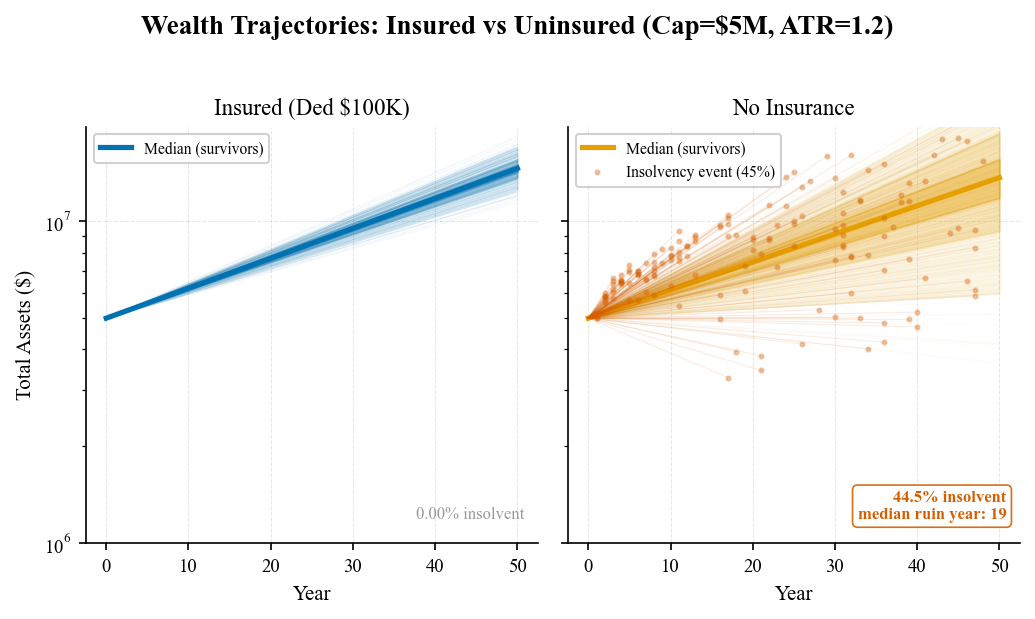

In [29]:
CAP, ATR, DED = 5_000_000, 1.2, 100_000
A0 = CAP
years = np.arange(51)
bands = [(5, 95, 0.10), (25, 75, 0.20), (40, 60, 0.35)]

def load_ruin_years(key):
    """Detect ruin year per sim from trailing zeros in annual_losses.
    Returns -1 for survivors, ruin year (0-indexed) for ruined paths."""
    path = RESULTS_DIR / f'{key}.pkl'
    with open(path, 'rb') as f:
        data = pickle.load(f)
    losses = data.annual_losses
    n_sims, n_years = losses.shape
    last_active = np.full(n_sims, -1, dtype=int)
    for yr in range(n_years - 1, -1, -1):
        mask = (losses[:, yr] != 0) & (last_active == -1)
        last_active[mask] = yr
    ruined = last_active < (n_years - 2)
    ruin_year = np.where(ruined, last_active + 1, -1)
    del data
    gc.collect()
    return ruin_year

fig, axes = plt.subplots(1, 2, figsize=(7.0, 4.0), sharey=True)

for ax_idx, (label, noins_flag, ded_val, base_color) in enumerate([
    (f'Insured (Ded {DED_LABELS[DED]})', False, DED, PAL['blue']),
    ('No Insurance', True, None, PAL['orange']),
]):
    ax = axes[ax_idx]
    k = find_key(CAP, ATR, ded=ded_val, noins=noins_flag)
    if k is None:
        ax.set_title(f'{label} (no data)'); continue

    g = sim[k]['gr']
    fa = sim[k]['fa']
    ry = load_ruin_years(k)

    survived = ry == -1
    ruined = ry >= 0
    n_ruined = ruined.sum()
    ruin_pct = n_ruined / len(g)
    g_surv = g[survived]

    rng = np.random.default_rng(42)

    # --- Surviving paths: spaghetti + fan ---
    n_surv_sample = min(300, survived.sum())
    surv_idx = rng.choice(np.where(survived)[0], size=n_surv_sample, replace=False)
    for si in surv_idx:
        y = A0 * np.exp(g[si] * years)
        ax.plot(years, y, color=base_color, alpha=0.04, lw=LW_THIN)

    for lo, hi, alpha in bands:
        g_lo = np.percentile(g_surv, lo)
        g_hi = np.percentile(g_surv, hi)
        ax.fill_between(years, A0 * np.exp(g_lo * years),
                        A0 * np.exp(g_hi * years), color=base_color, alpha=alpha)

    ax.plot(years, A0 * np.exp(np.median(g_surv) * years),
            color=base_color, lw=LW_EM, label='Median (survivors)')

    # --- Ruined paths: terminated trajectories + insolvency dots ---
    if n_ruined > 50:
        n_ruin_sample = min(150, n_ruined)
        ruin_idx = rng.choice(np.where(ruined)[0], size=n_ruin_sample, replace=False)
        ruin_x, ruin_y = [], []
        for si in ruin_idx:
            ruin_yr = ry[si]
            if ruin_yr <= 0: continue
            g_to_ruin = np.log(float(fa[si]) / A0) / ruin_yr
            t_path = np.arange(ruin_yr + 1)
            y_path = A0 * np.exp(g_to_ruin * t_path)
            ax.plot(t_path, y_path, color=PAL['vermillion'], alpha=0.12, lw=0.5)
            ruin_x.append(ruin_yr)
            ruin_y.append(y_path[-1])

        ax.scatter(ruin_x, ruin_y, color=PAL['vermillion'], s=4, alpha=0.3,
                   zorder=4, label=f'Insolvency event ({ruin_pct:.0%})')

        median_ry = np.median(ry[ruined])
        ax.text(0.97, 0.05,
                f'{ruin_pct:.1%} insolvent\nmedian ruin year: {median_ry:.0f}',
                transform=ax.transAxes, fontsize=8, ha='right', va='bottom',
                color=PAL['vermillion'], fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.9,
                          ec=PAL['vermillion'], lw=0.8))
    elif ruin_pct > 0:
        ax.text(0.97, 0.05, f'{ruin_pct:.2%} insolvent',
                transform=ax.transAxes, fontsize=8, ha='right', va='bottom',
                color=PAL['gray'])

    ax.set_yscale('log')
    ax.set_ylim(1e6, None)
    ax.set_title(label, fontsize=11)
    ax.set_xlabel('Year')
    ax.legend(loc='upper left', fontsize=7.5)

axes[0].set_ylabel('Total Assets ($)')
fig.suptitle(
    f'Wealth Trajectories: Insured vs Uninsured (Cap={fmt(CAP)}, ATR={ATR})',
    fontsize=13, fontweight='bold', y=1.02,
)
fig.tight_layout()
save(fig, 'wealth_fan_chart')
plt.show()